In [54]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 绘图设置
# 风格
plt.style.use('seaborn-v0_8-whitegrid')
# 全局设置
config = {'font.family':'Times New Roman', 'figure.dpi':500, 'figure.figsize':(10,8), 'axes.labelsize':20}
plt.rcParams.update(config)
# 配色
from matplotlib.colors import LinearSegmentedColormap
colors = ['#3e324a', '#475d7b', '#97c6c0', '#e26e1b', '#4df8e8'] # FireFly!
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# 其它
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

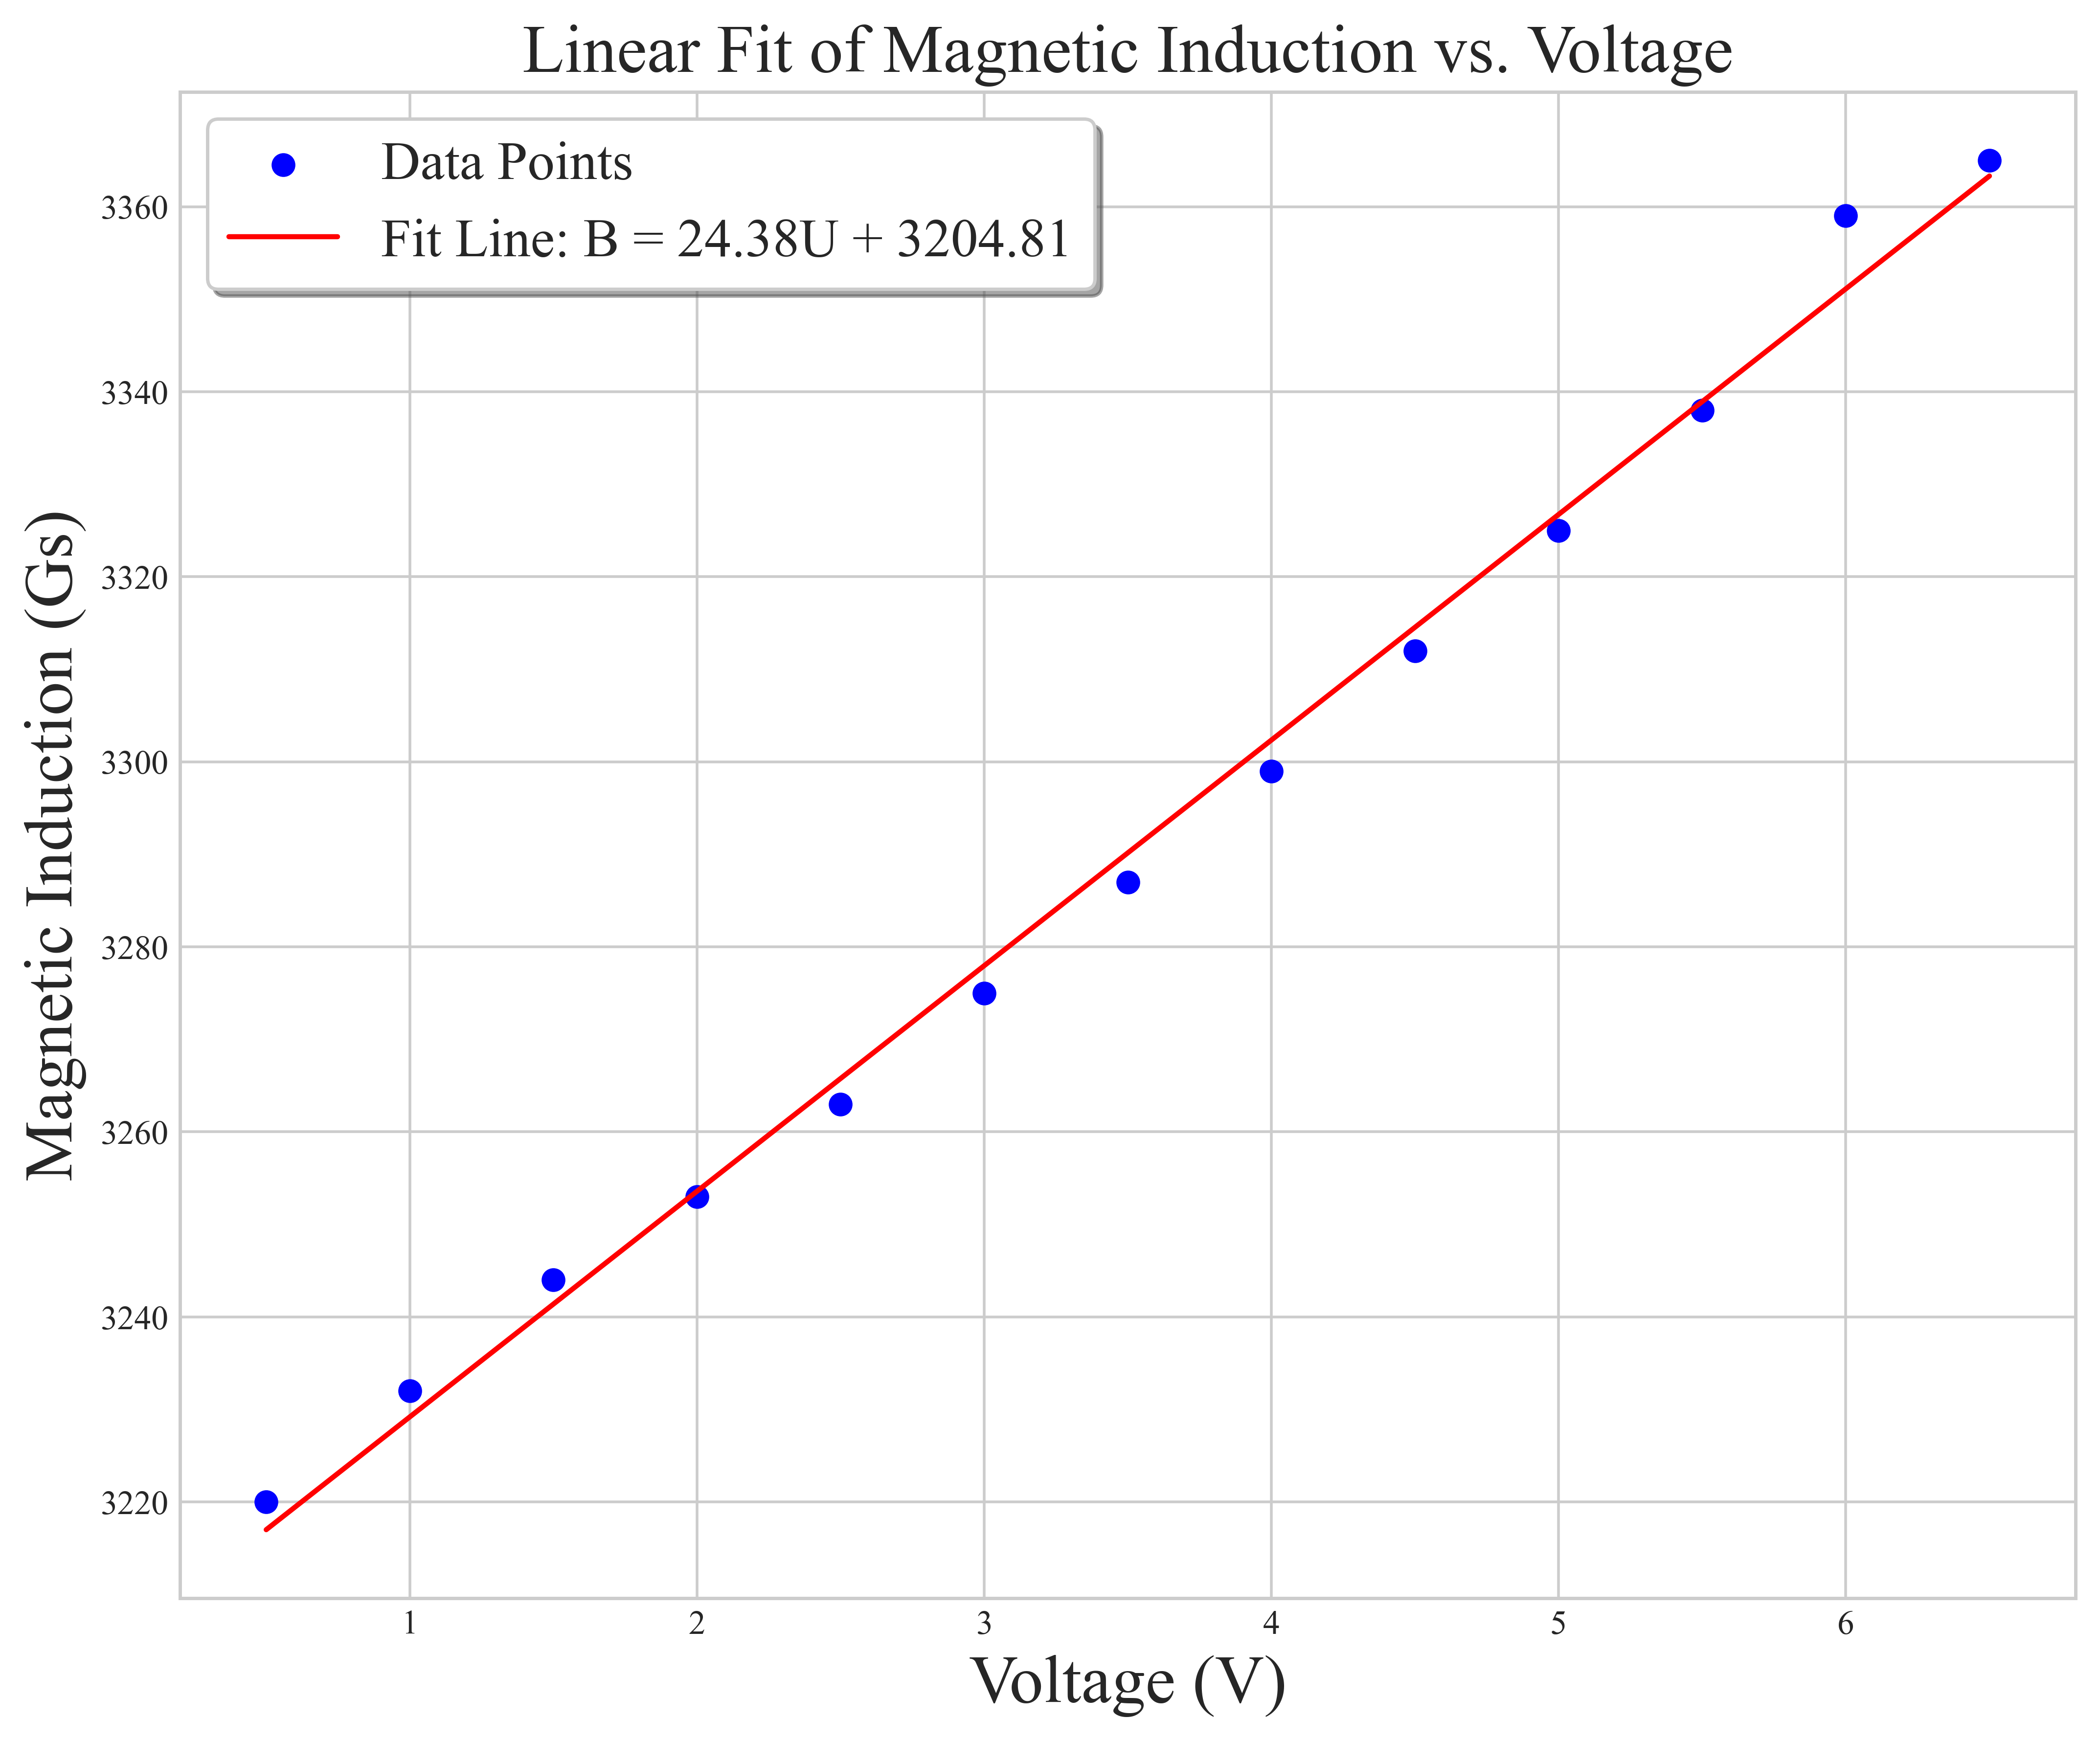

In [55]:
# 前置流程（实验一）

# 实验一数据
b = np.array([3220, 3232, 3244, 3253, 3263, 3275, 3287, 3299, 3312, 3325, 3338, 3359, 3365])  # Magnetic Induction (Gs)
u = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5])  # Voltage (V)

# 线性拟合
slope, intercept, r_value, p_value, std_err = linregress(u, b)
def vmc(vOltage, sLope=slope, iNtercept=intercept):
    '''
    Conversion relationship between main excitation coil voltage and magnetic induction intensity
    input: voltage (V), slope*, intercept*
    output: magnetic_induction_intensity (Gs = 1e-4 T)
    '''
    return sLope * vOltage + iNtercept

# 作图
plt.figure()
plt.scatter(u, b, label='Data Points', color='blue')
plt.plot(u, vmc(u), color='red', label=f'Fit Line: B = {slope:.2f}U + {intercept:.2f}')
plt.xlabel('Voltage (V)')
plt.ylabel('Magnetic Induction (Gs)')
plt.title('Linear Fit of Magnetic Induction vs. Voltage', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

In [56]:
# 先处理data1.csv（数据清洗与规整化）
# 大致流程：
# 1. 平均周期化
# 2. 滤波
# 3. 截取片段
# 4. 方案一：拟合李萨如图；方案二：拟合时序图
# 5. 后续计算

# 加载数据
data1 = pd.read_csv('data/data1.csv', skiprows=1)
t1 = data1.iloc[:, 0] # 时间单位为“1个单位时间”
x1 = data1.iloc[:, 1]
y1 = data1.iloc[:, 2]

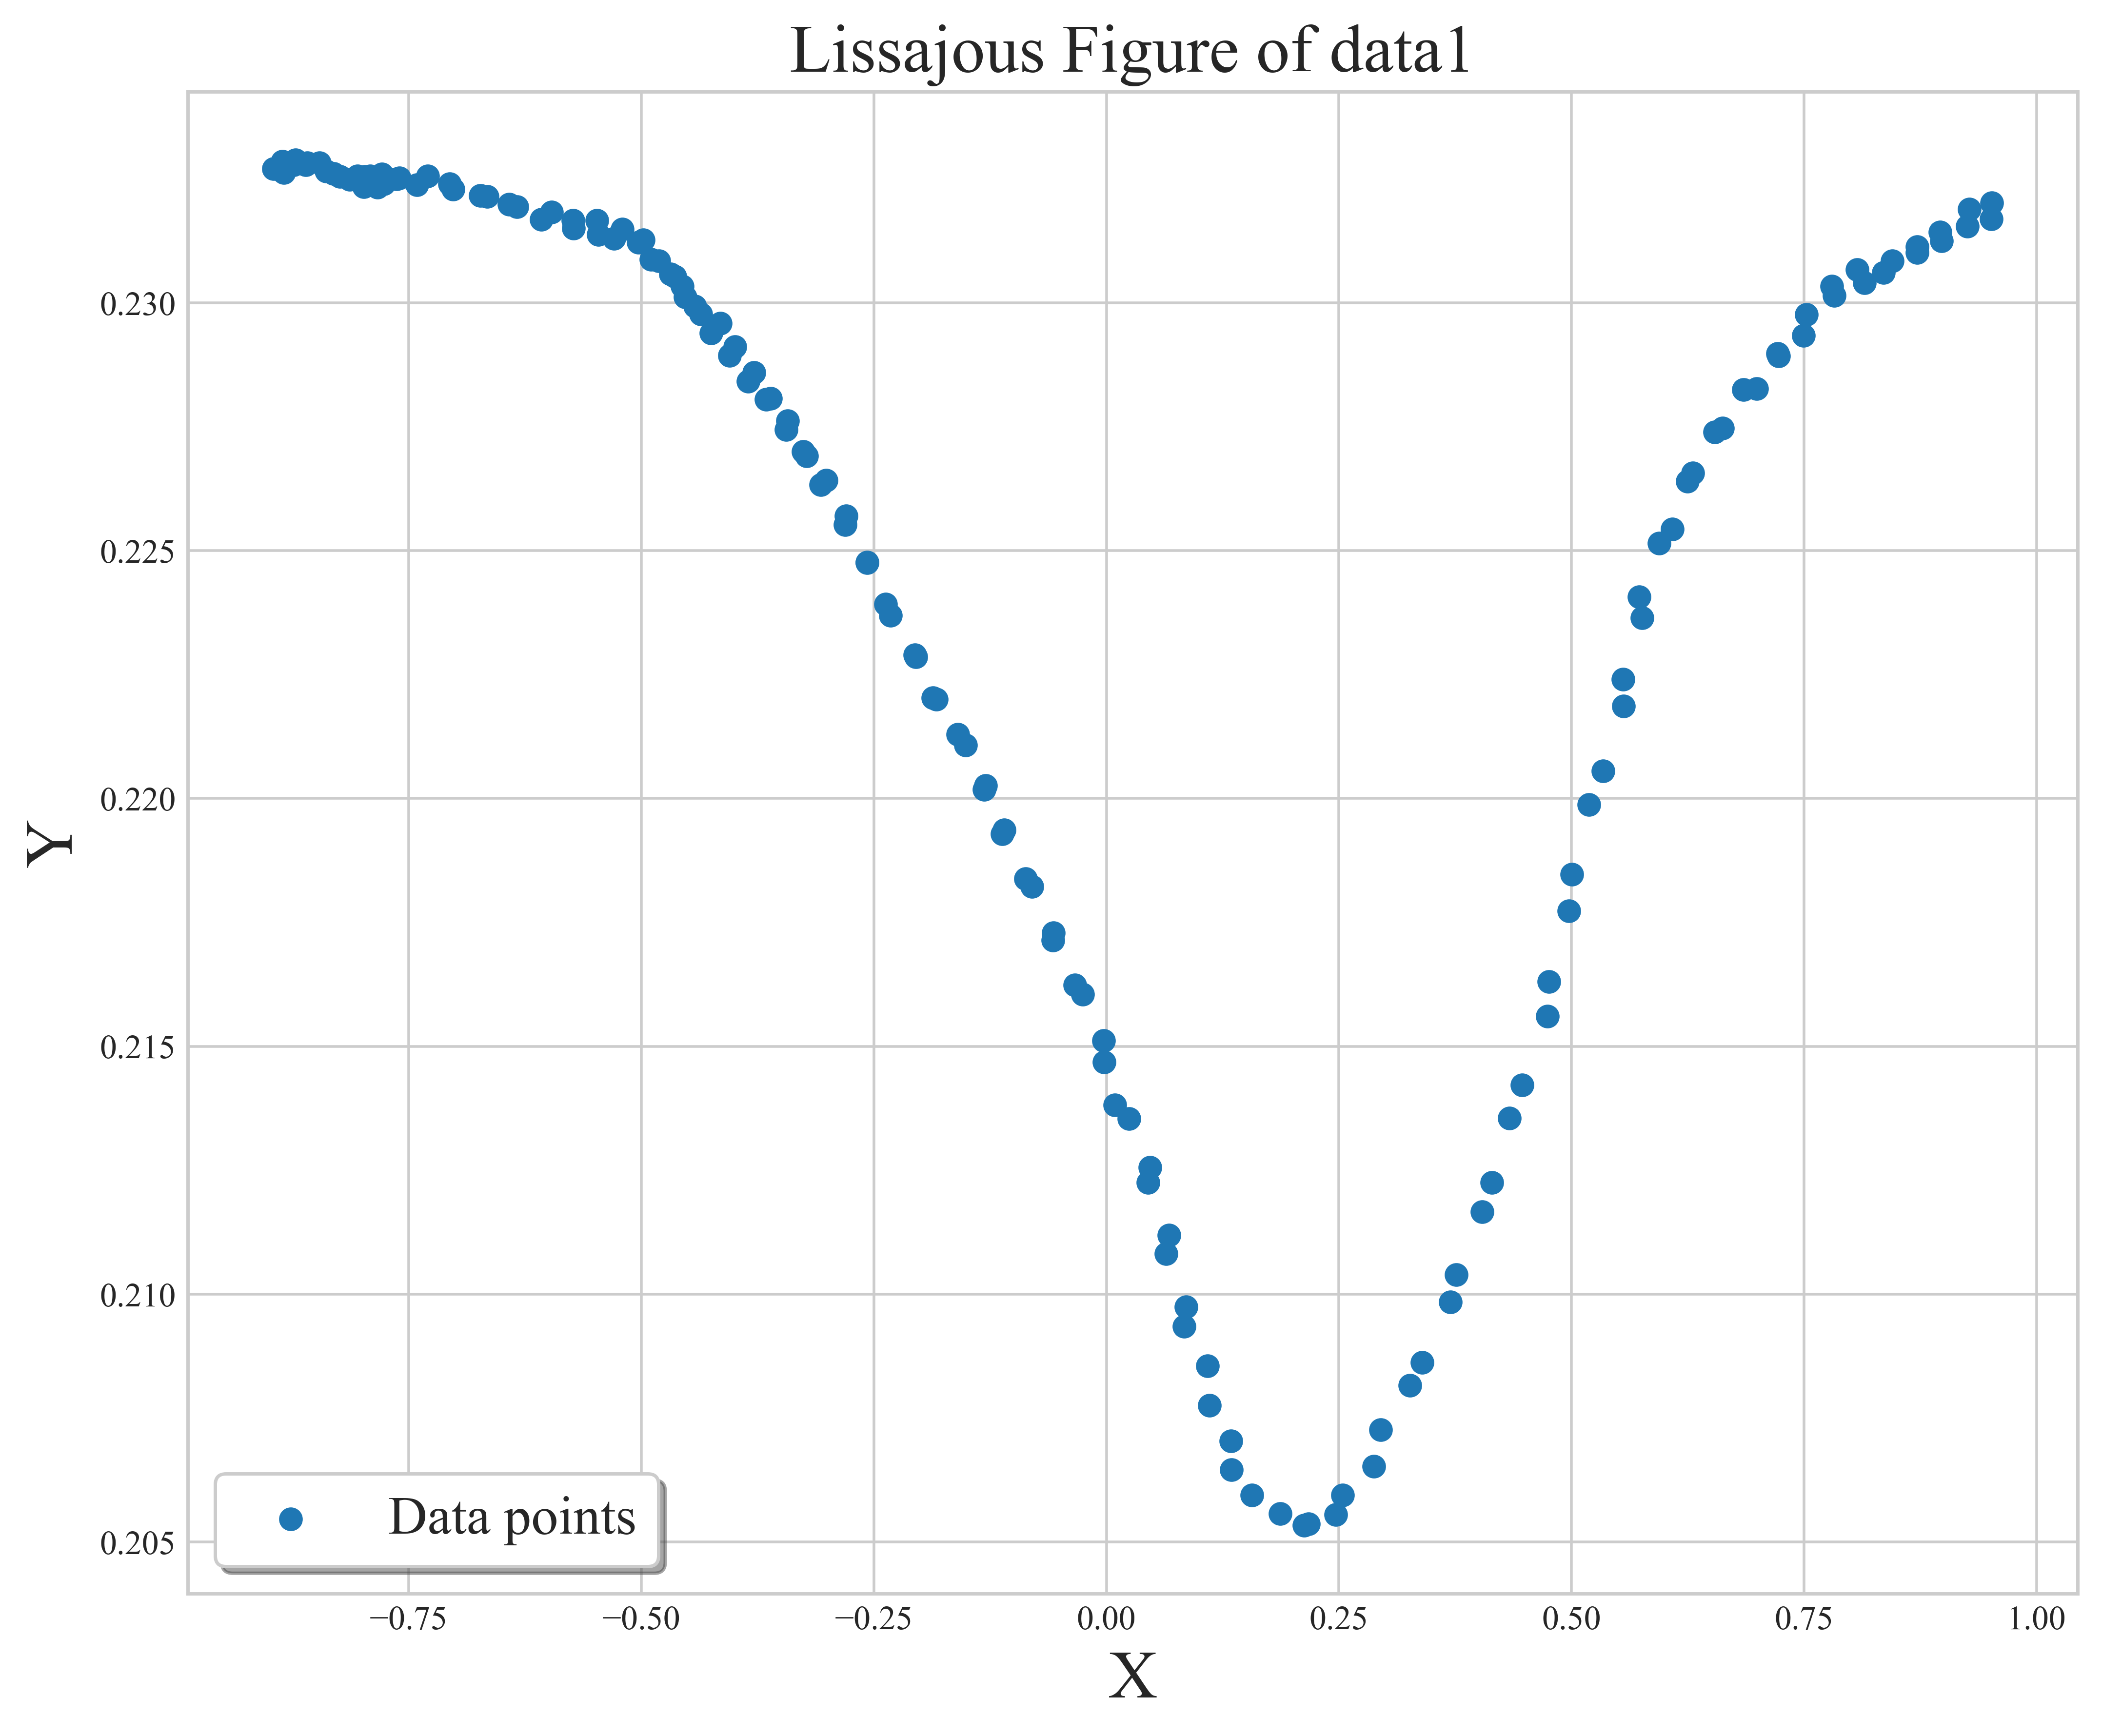

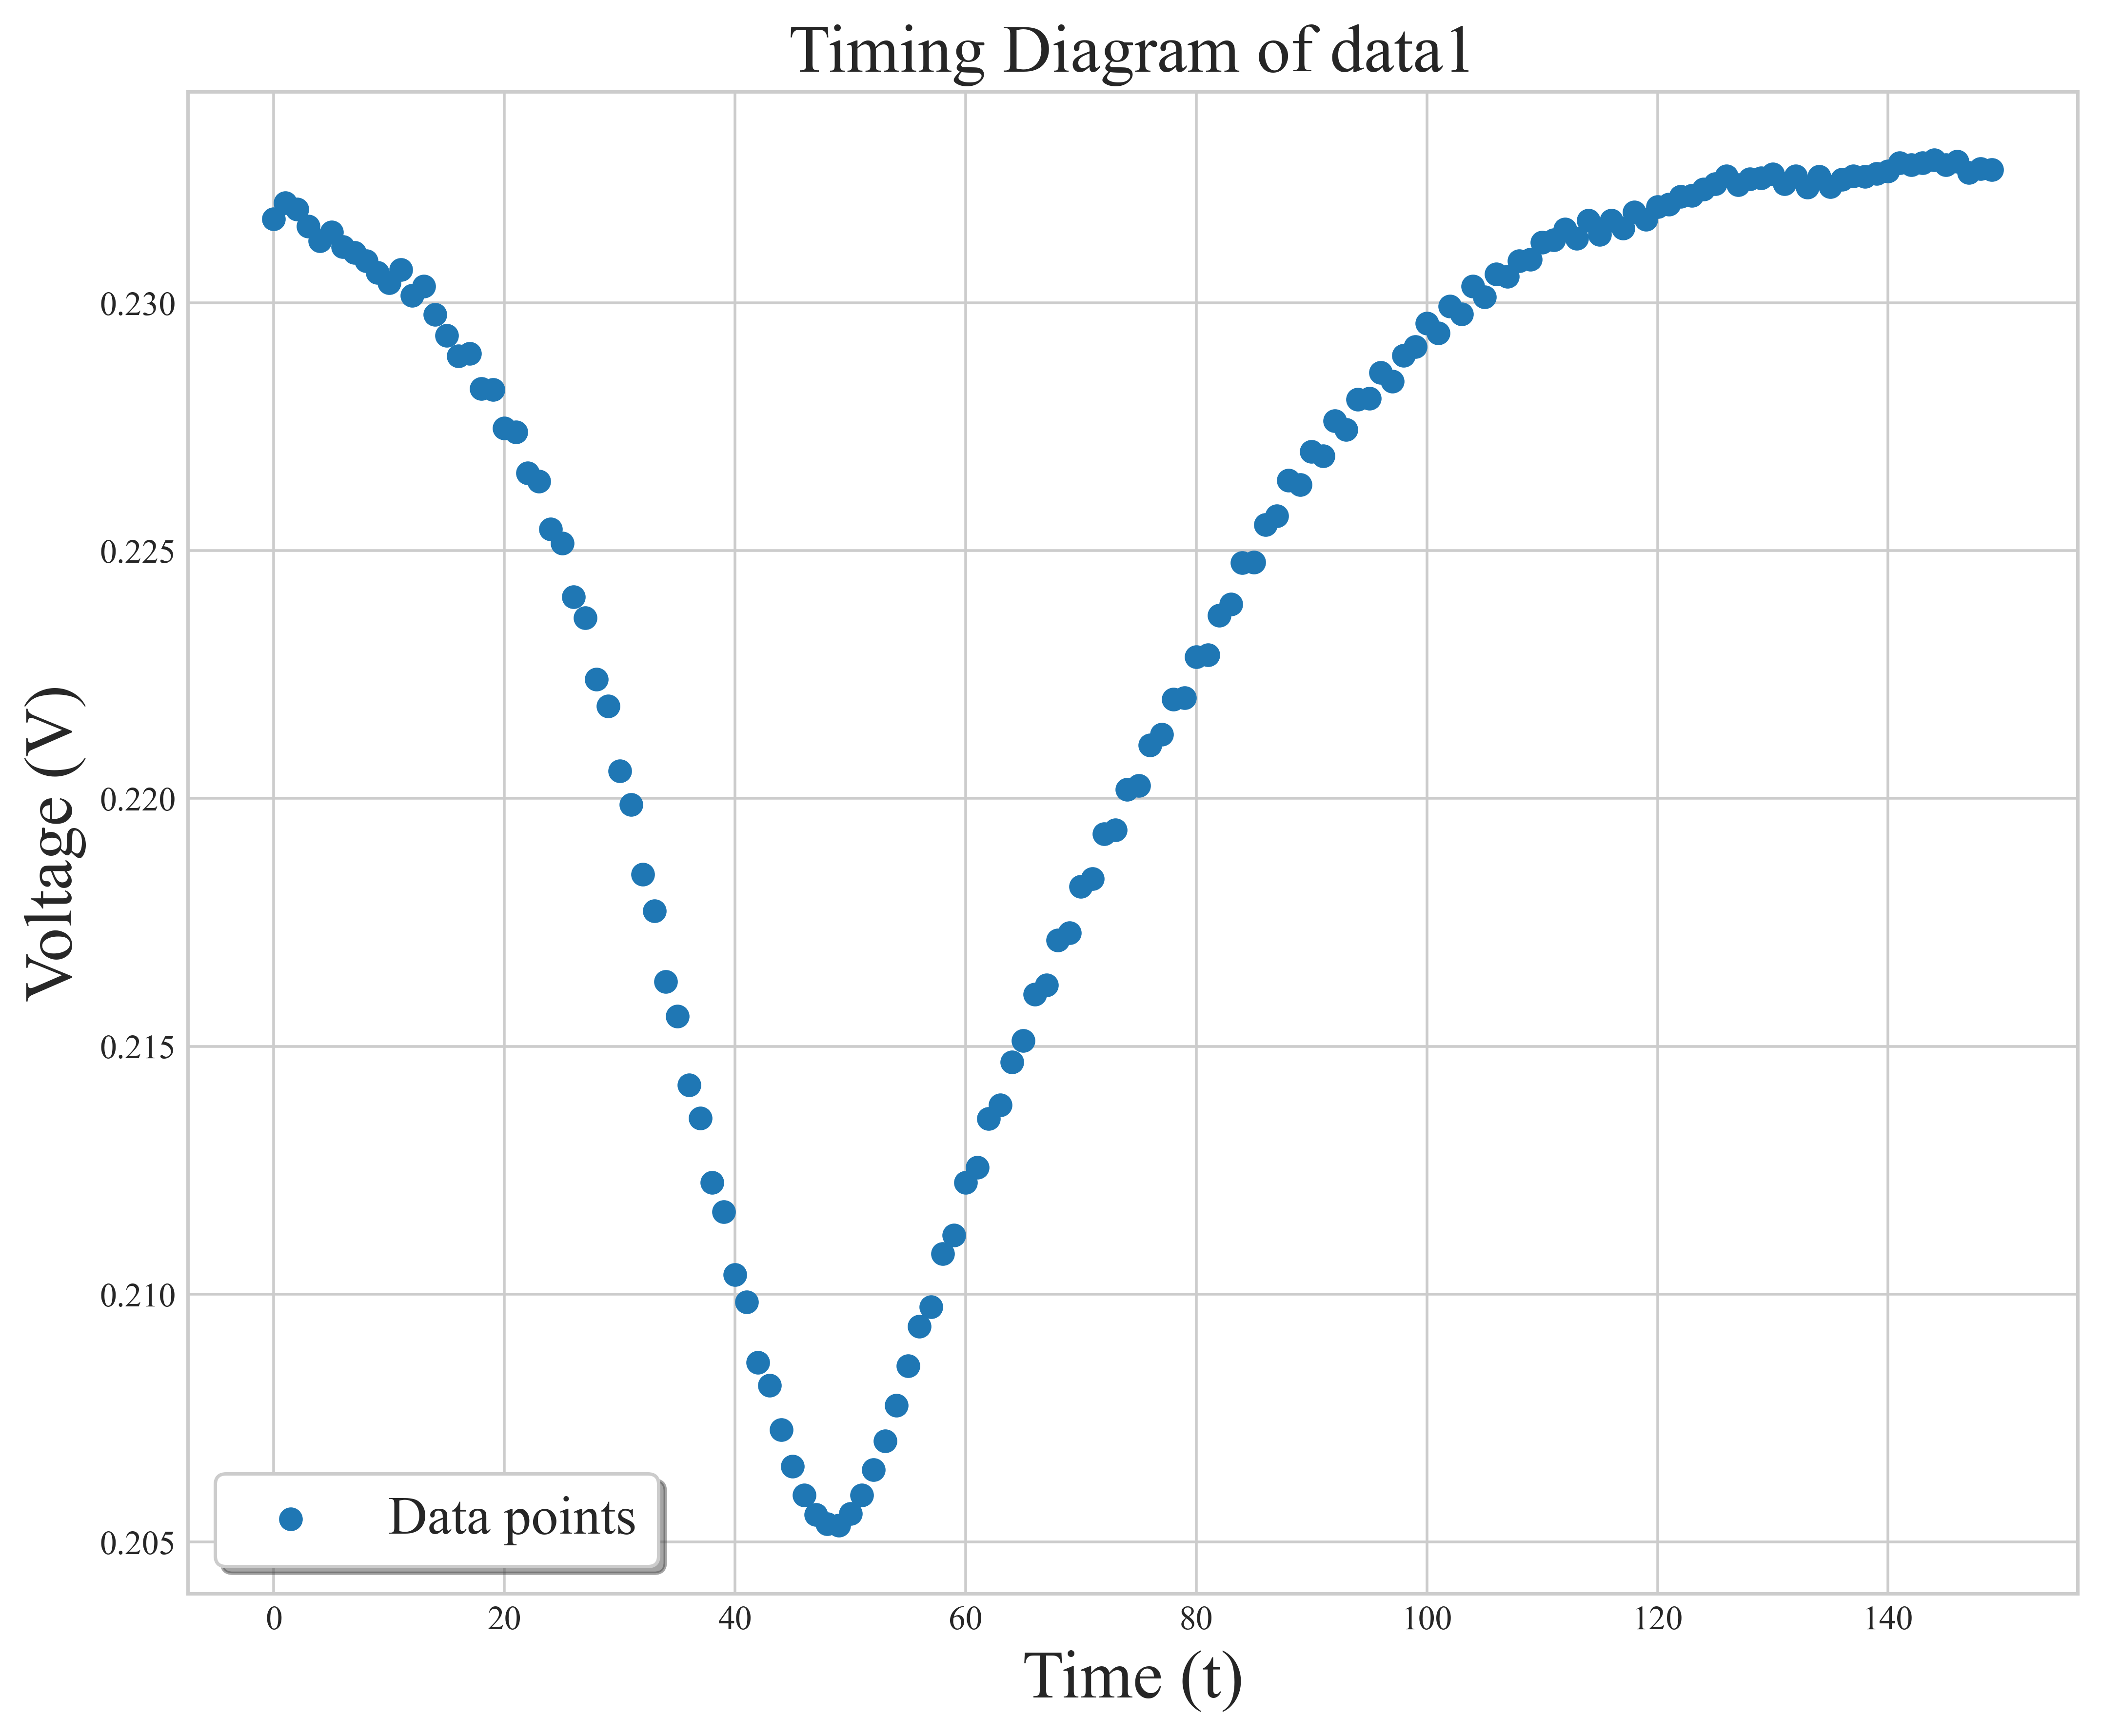

In [57]:
# 平均周期化

def average_periodization(x, t, T):
    '''
    把多个周期平均为一个周期  
    input: x: ndarray, t: ndarray, T: int;  
    output: average_data: DataFrame.
    '''
    num_cycles = len(t) // T
    segments = [x[i * T:(i + 1) * T] for i in range(num_cycles)]
    average_cycle = np.mean(segments, axis=0)
    time_cycle = t[:T]
    average_data = pd.DataFrame({'time': time_cycle, 'X': average_cycle})
    return average_data

# x数据
T_x1 = 400
average_xt1 = average_periodization(x1, t1, T_x1)
# 滤波
window_length = 13  # 窗口长度，可以根据实际情况调整
polyorder = 3       # 多项式阶数，一般为2或3
smoothed_x1 = savgol_filter(average_xt1['X'].values, window_length, polyorder)
# 截取
selected_x1 = smoothed_x1[50:200]

# y数据
T_y1 = 400
average_yt1 = average_periodization(y1, t1, T_y1)
# 滤波
smoothed_y1 = savgol_filter(average_yt1['X'].values, window_length, polyorder)
selected_y1 = smoothed_y1[50:200]

# 时间序列
selected_t1 = np.arange(150)

# 初步绘制李萨如图和时序图
plt.figure()
plt.scatter(selected_x1, selected_y1, label='Data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lissajous Figure of data1', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

plt.figure()
plt.scatter(selected_t1, selected_y1, label='Data points')
plt.xlabel('Time (t)')
plt.ylabel('Voltage (V)')
plt.title('Timing Diagram of data1', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

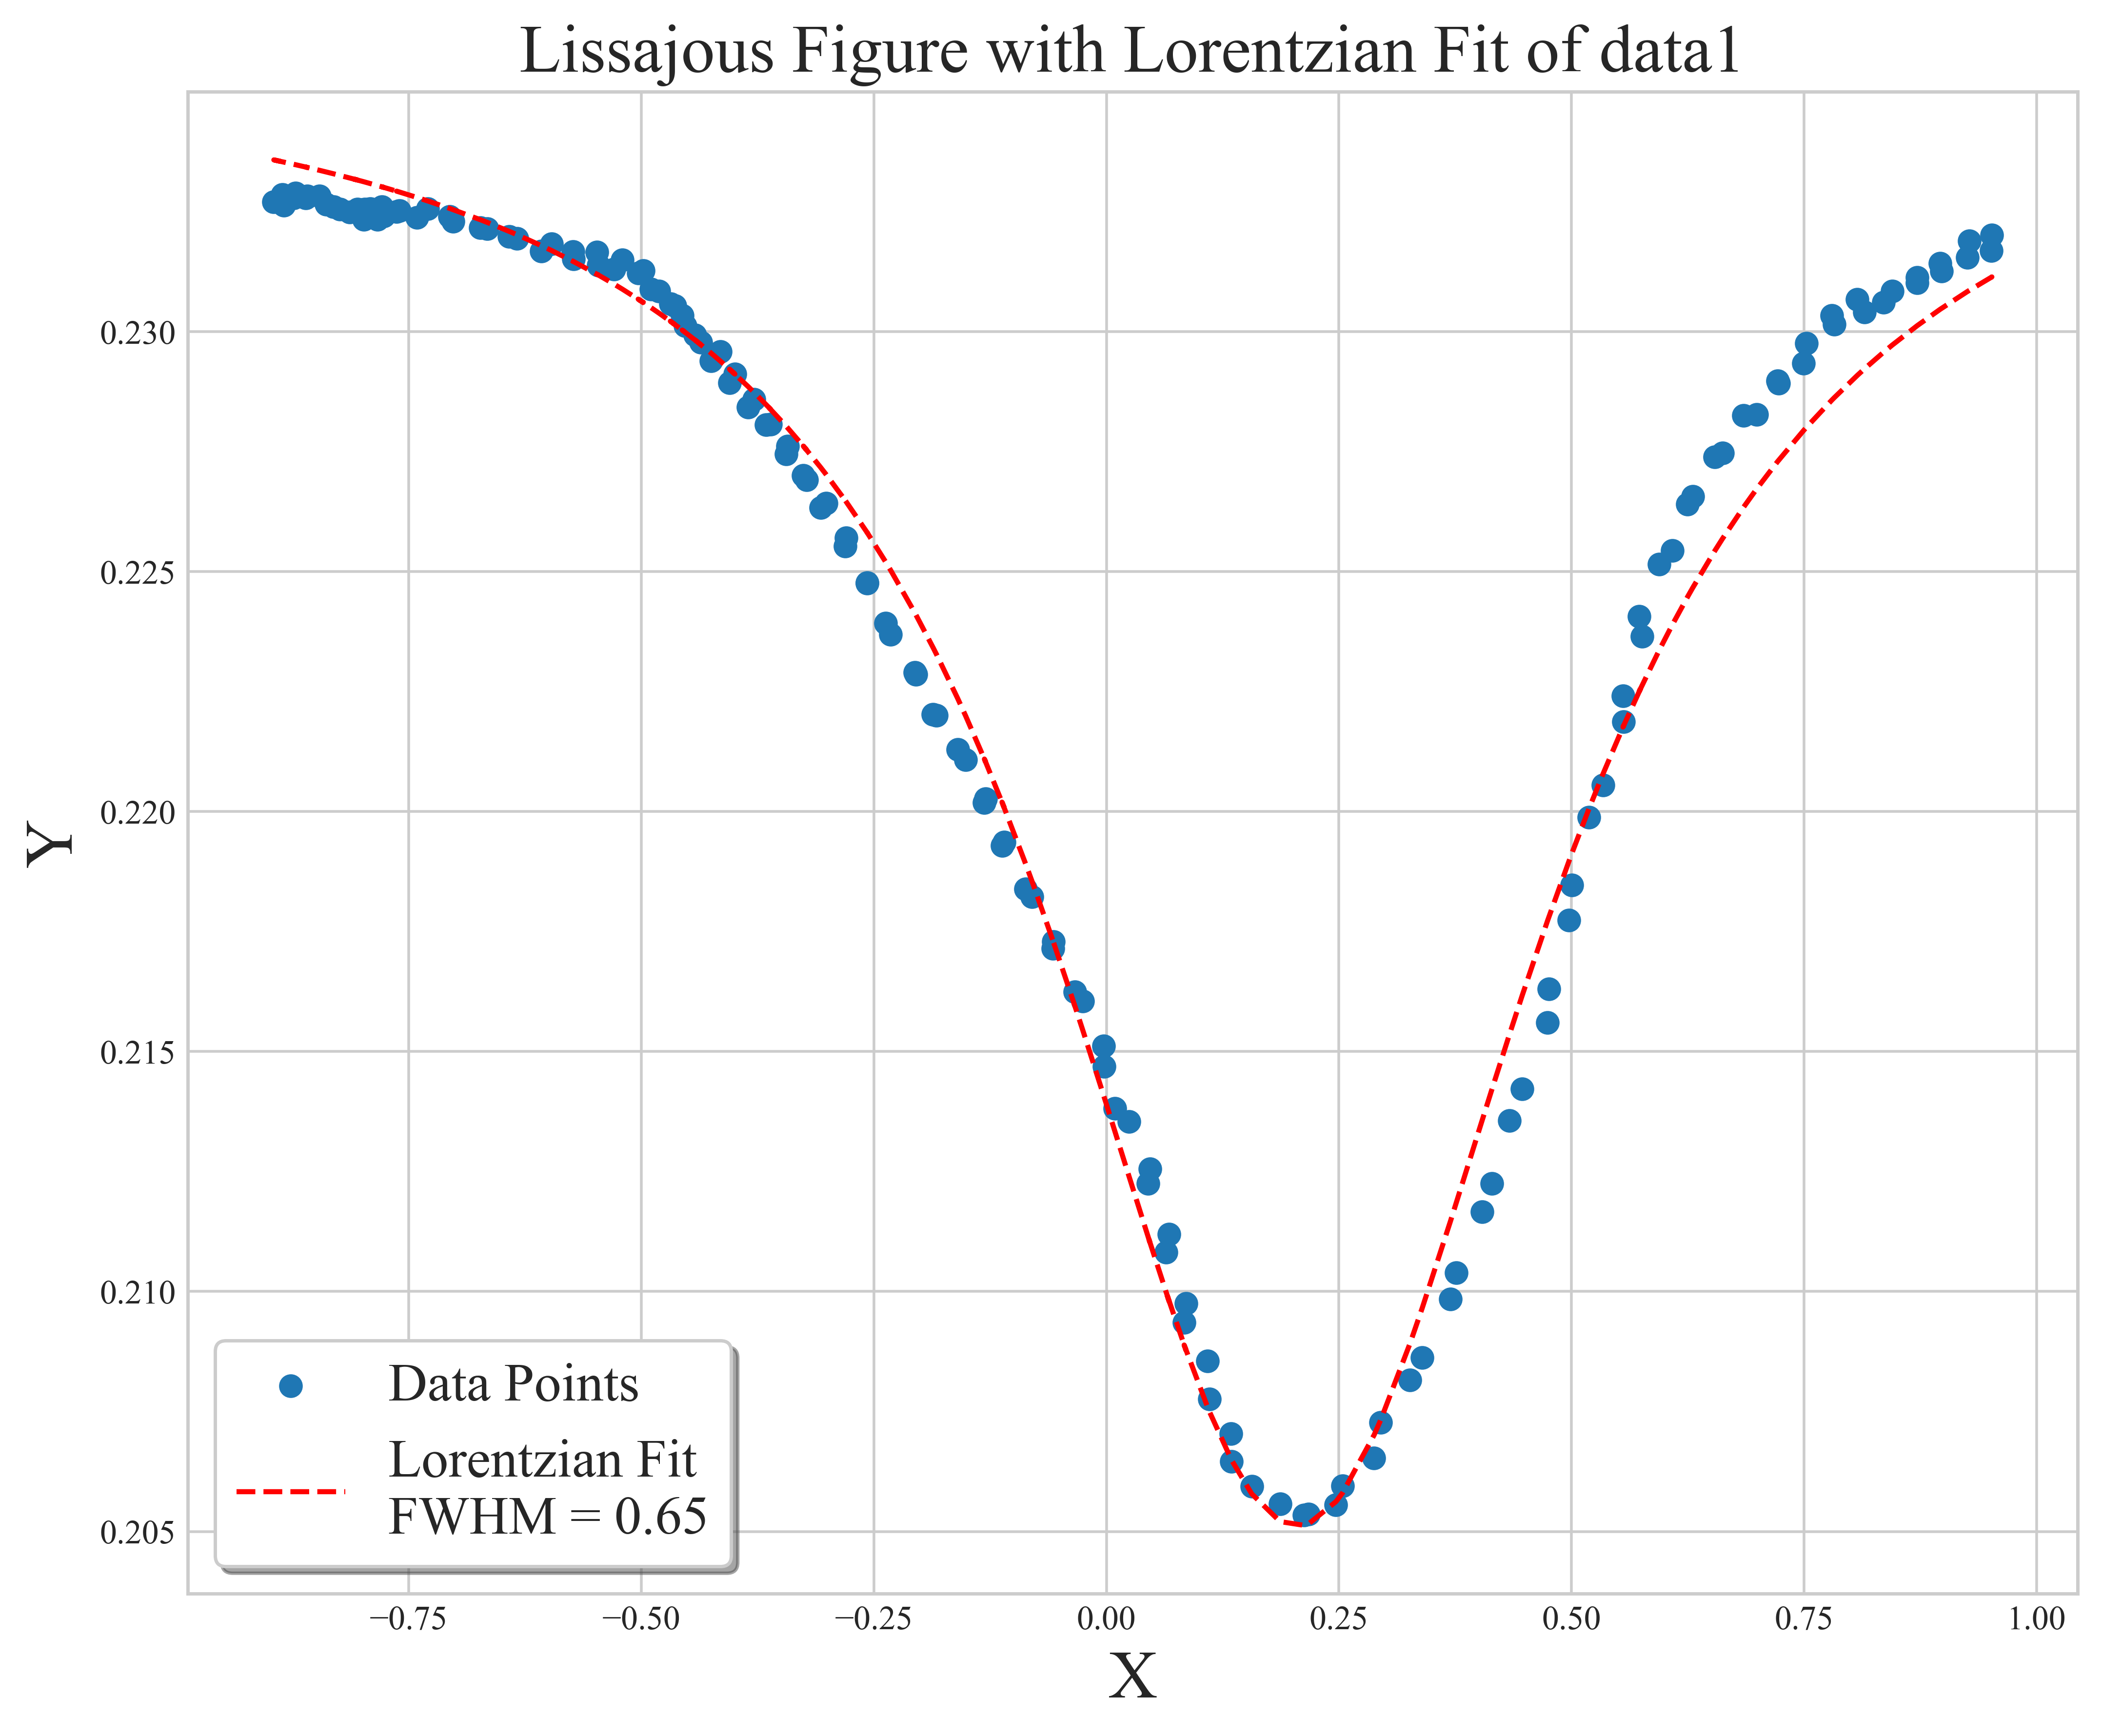

In [58]:
# 拟合李萨如图

def lorentzian(x, x0, gamma, A, y0):
    return y0 - A / (1 + ((x - x0) / (gamma / 2))**2)

params, covariance = curve_fit(lorentzian, selected_x1, selected_y1, p0=[selected_x1.mean(), 1, max(selected_y1) - min(selected_y1), min(selected_y1)])
x0, fwhm, A, y0 = params

plt.figure()
plt.scatter(selected_x1, selected_y1, label='Data Points')
plt.plot(selected_x1, lorentzian(selected_x1, *params), 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lissajous Figure with Lorentzian Fit of data1', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

In [59]:
# 后续计算

xpp = np.max(smoothed_x1) - np.min(smoothed_x1)
B_prime = (6.85 - 5.80) * slope
x2B = 2 * B_prime / xpp
Delta_B = fwhm * x2B * 1e-4
gamma = 2 * np.pi * 2.0036 * 5.79e-11 / (4.14e-21)
t2 = 2 / (gamma * Delta_B)
print(f'利用李萨如图拟合得到弛豫时间 T2 = {1e9 * t2:.4f} (ns)')

利用李萨如图拟合得到弛豫时间 T2 = 7.2838 (ns)


In [75]:
x2B

23.21129707112978

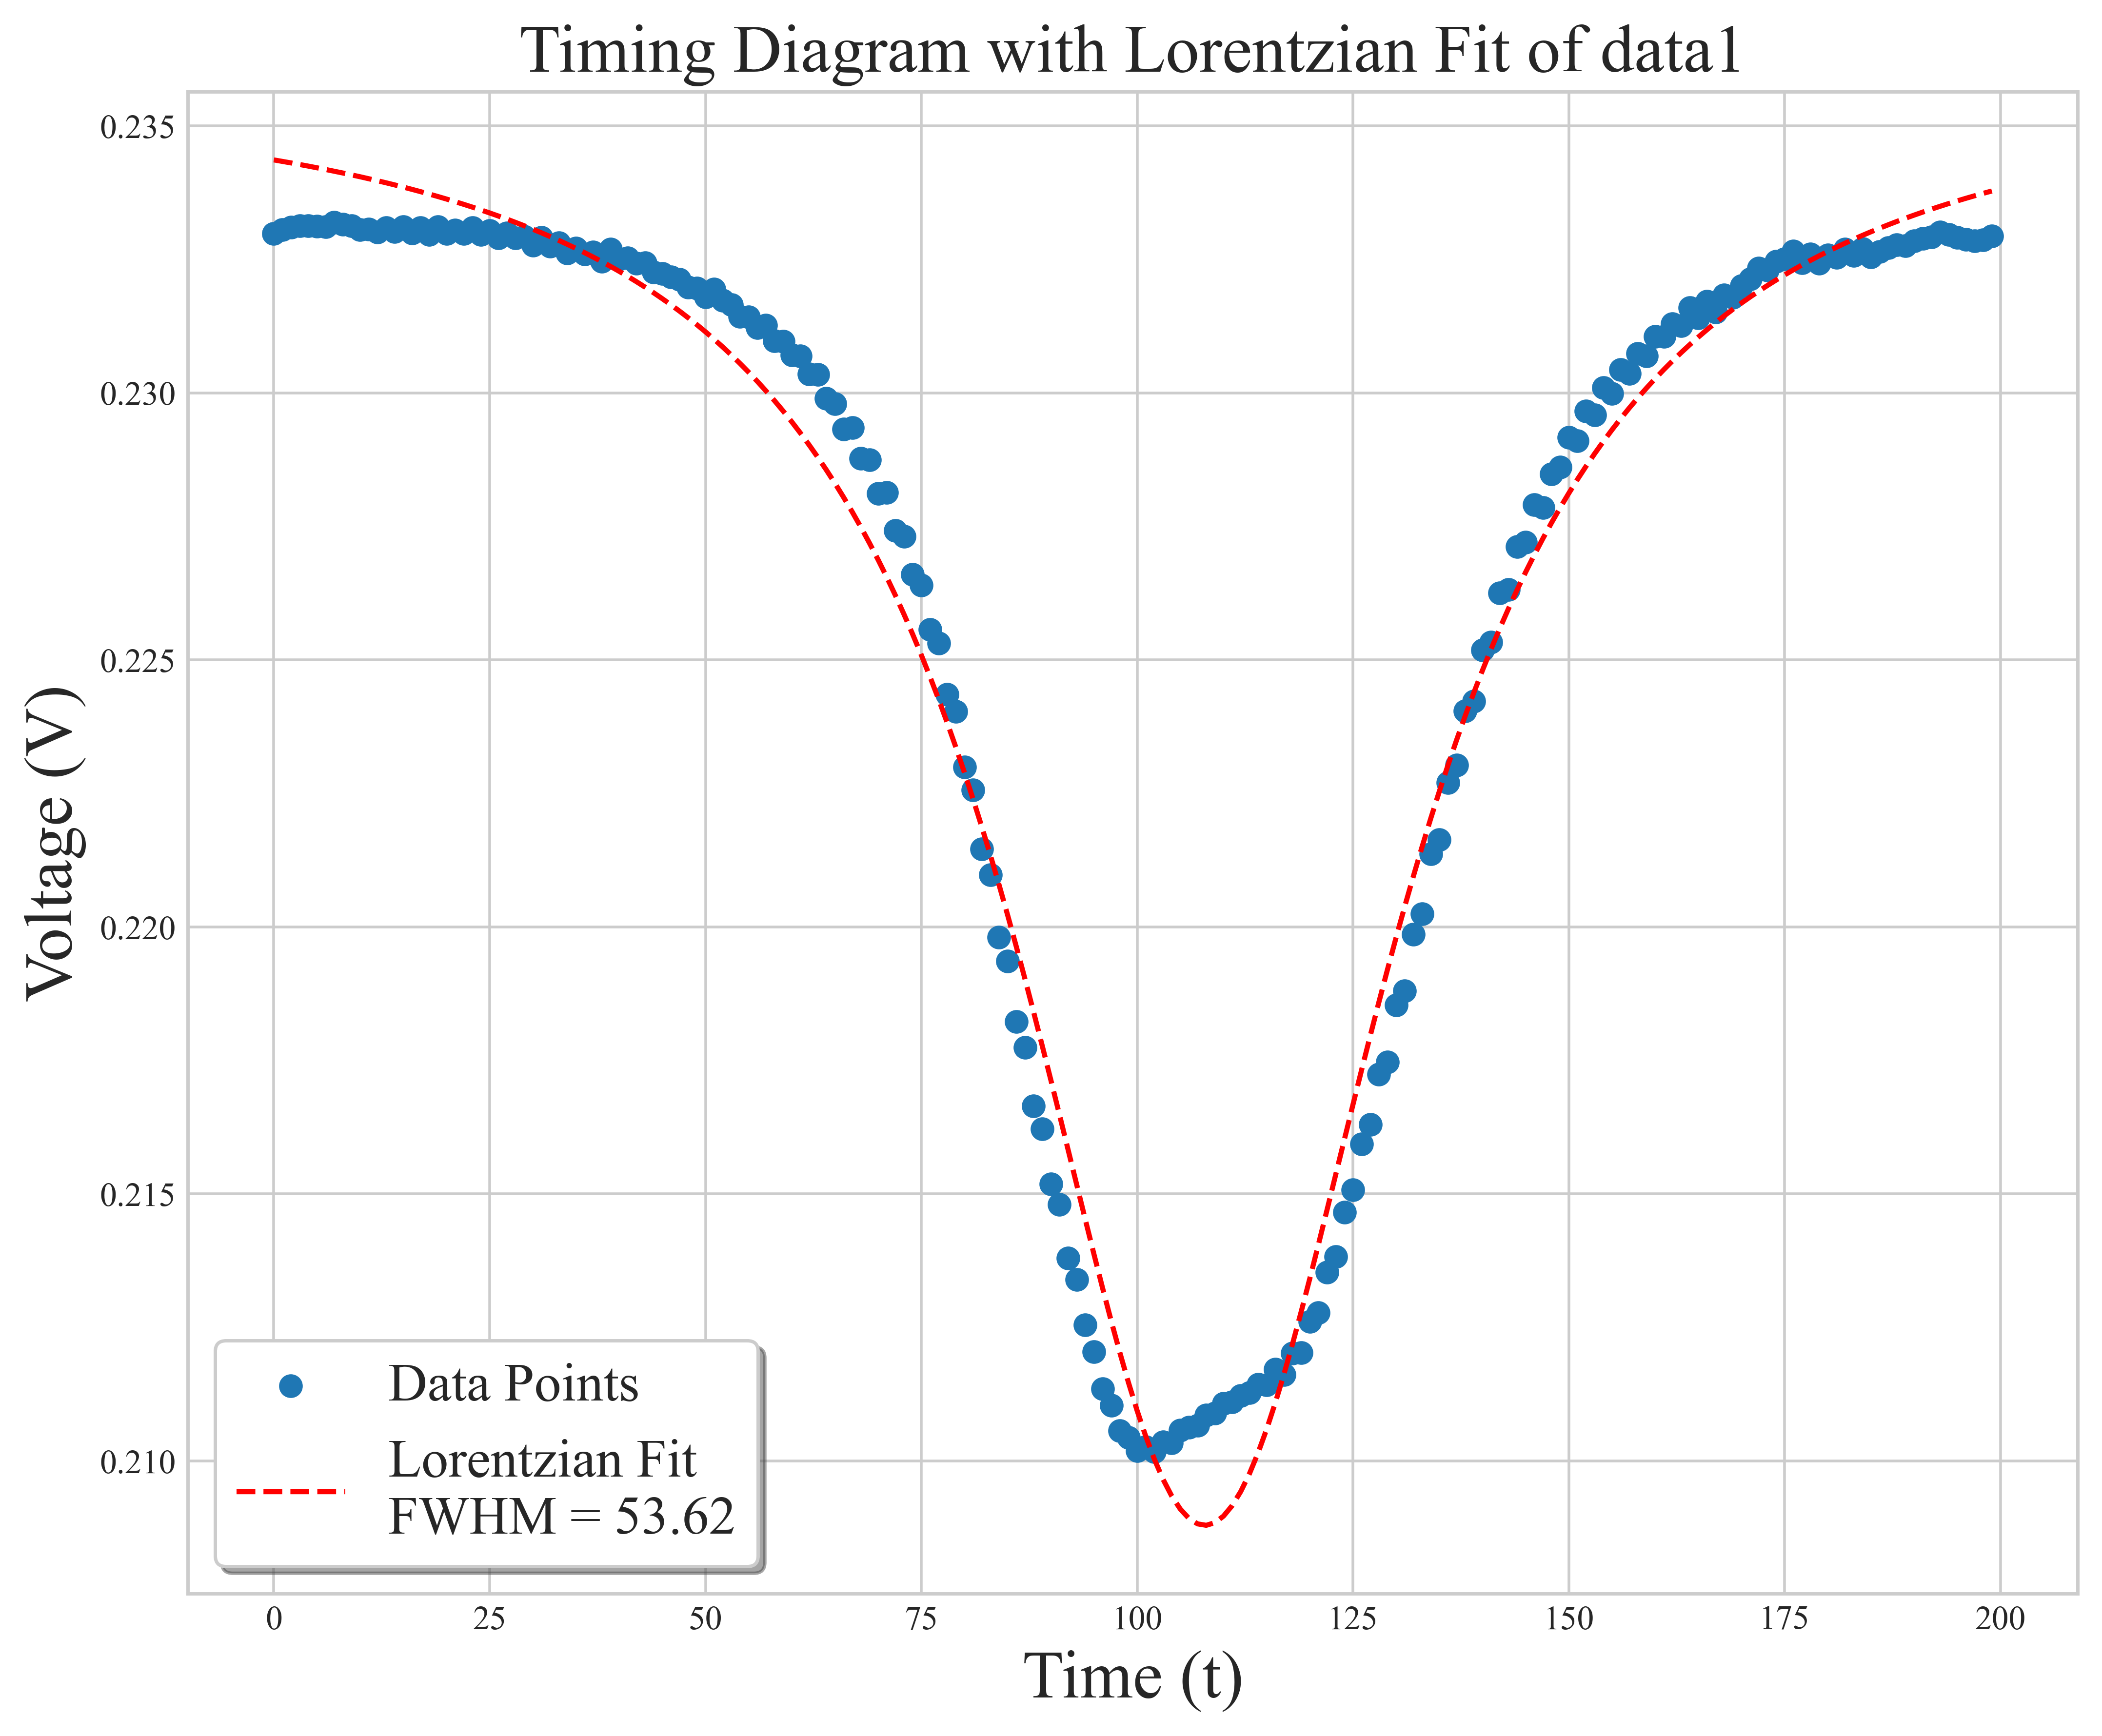

In [61]:
# 拟合时序图（1）

adjusted_yt1 = average_periodization(y1, t1, 200)
adjusted_y1 = savgol_filter(adjusted_yt1['X'].values, window_length, polyorder)
adjusted_t1 = adjusted_yt1['time'].values

initial_guess = [adjusted_t1[np.argmin(adjusted_y1)], 1, max(adjusted_y1) - min(adjusted_y1), min(adjusted_y1)]
params, covariance = curve_fit(lorentzian, adjusted_t1, adjusted_y1, p0=initial_guess)
t0, fwhm, A, y0 = params
fitted_y = lorentzian(adjusted_t1, *params)

plt.figure()
plt.scatter(adjusted_t1, adjusted_y1, label='Data Points')
plt.plot(adjusted_t1, fitted_y, 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('Time (t)')
plt.ylabel('Voltage (V)')
plt.title('Timing Diagram with Lorentzian Fit of data1', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

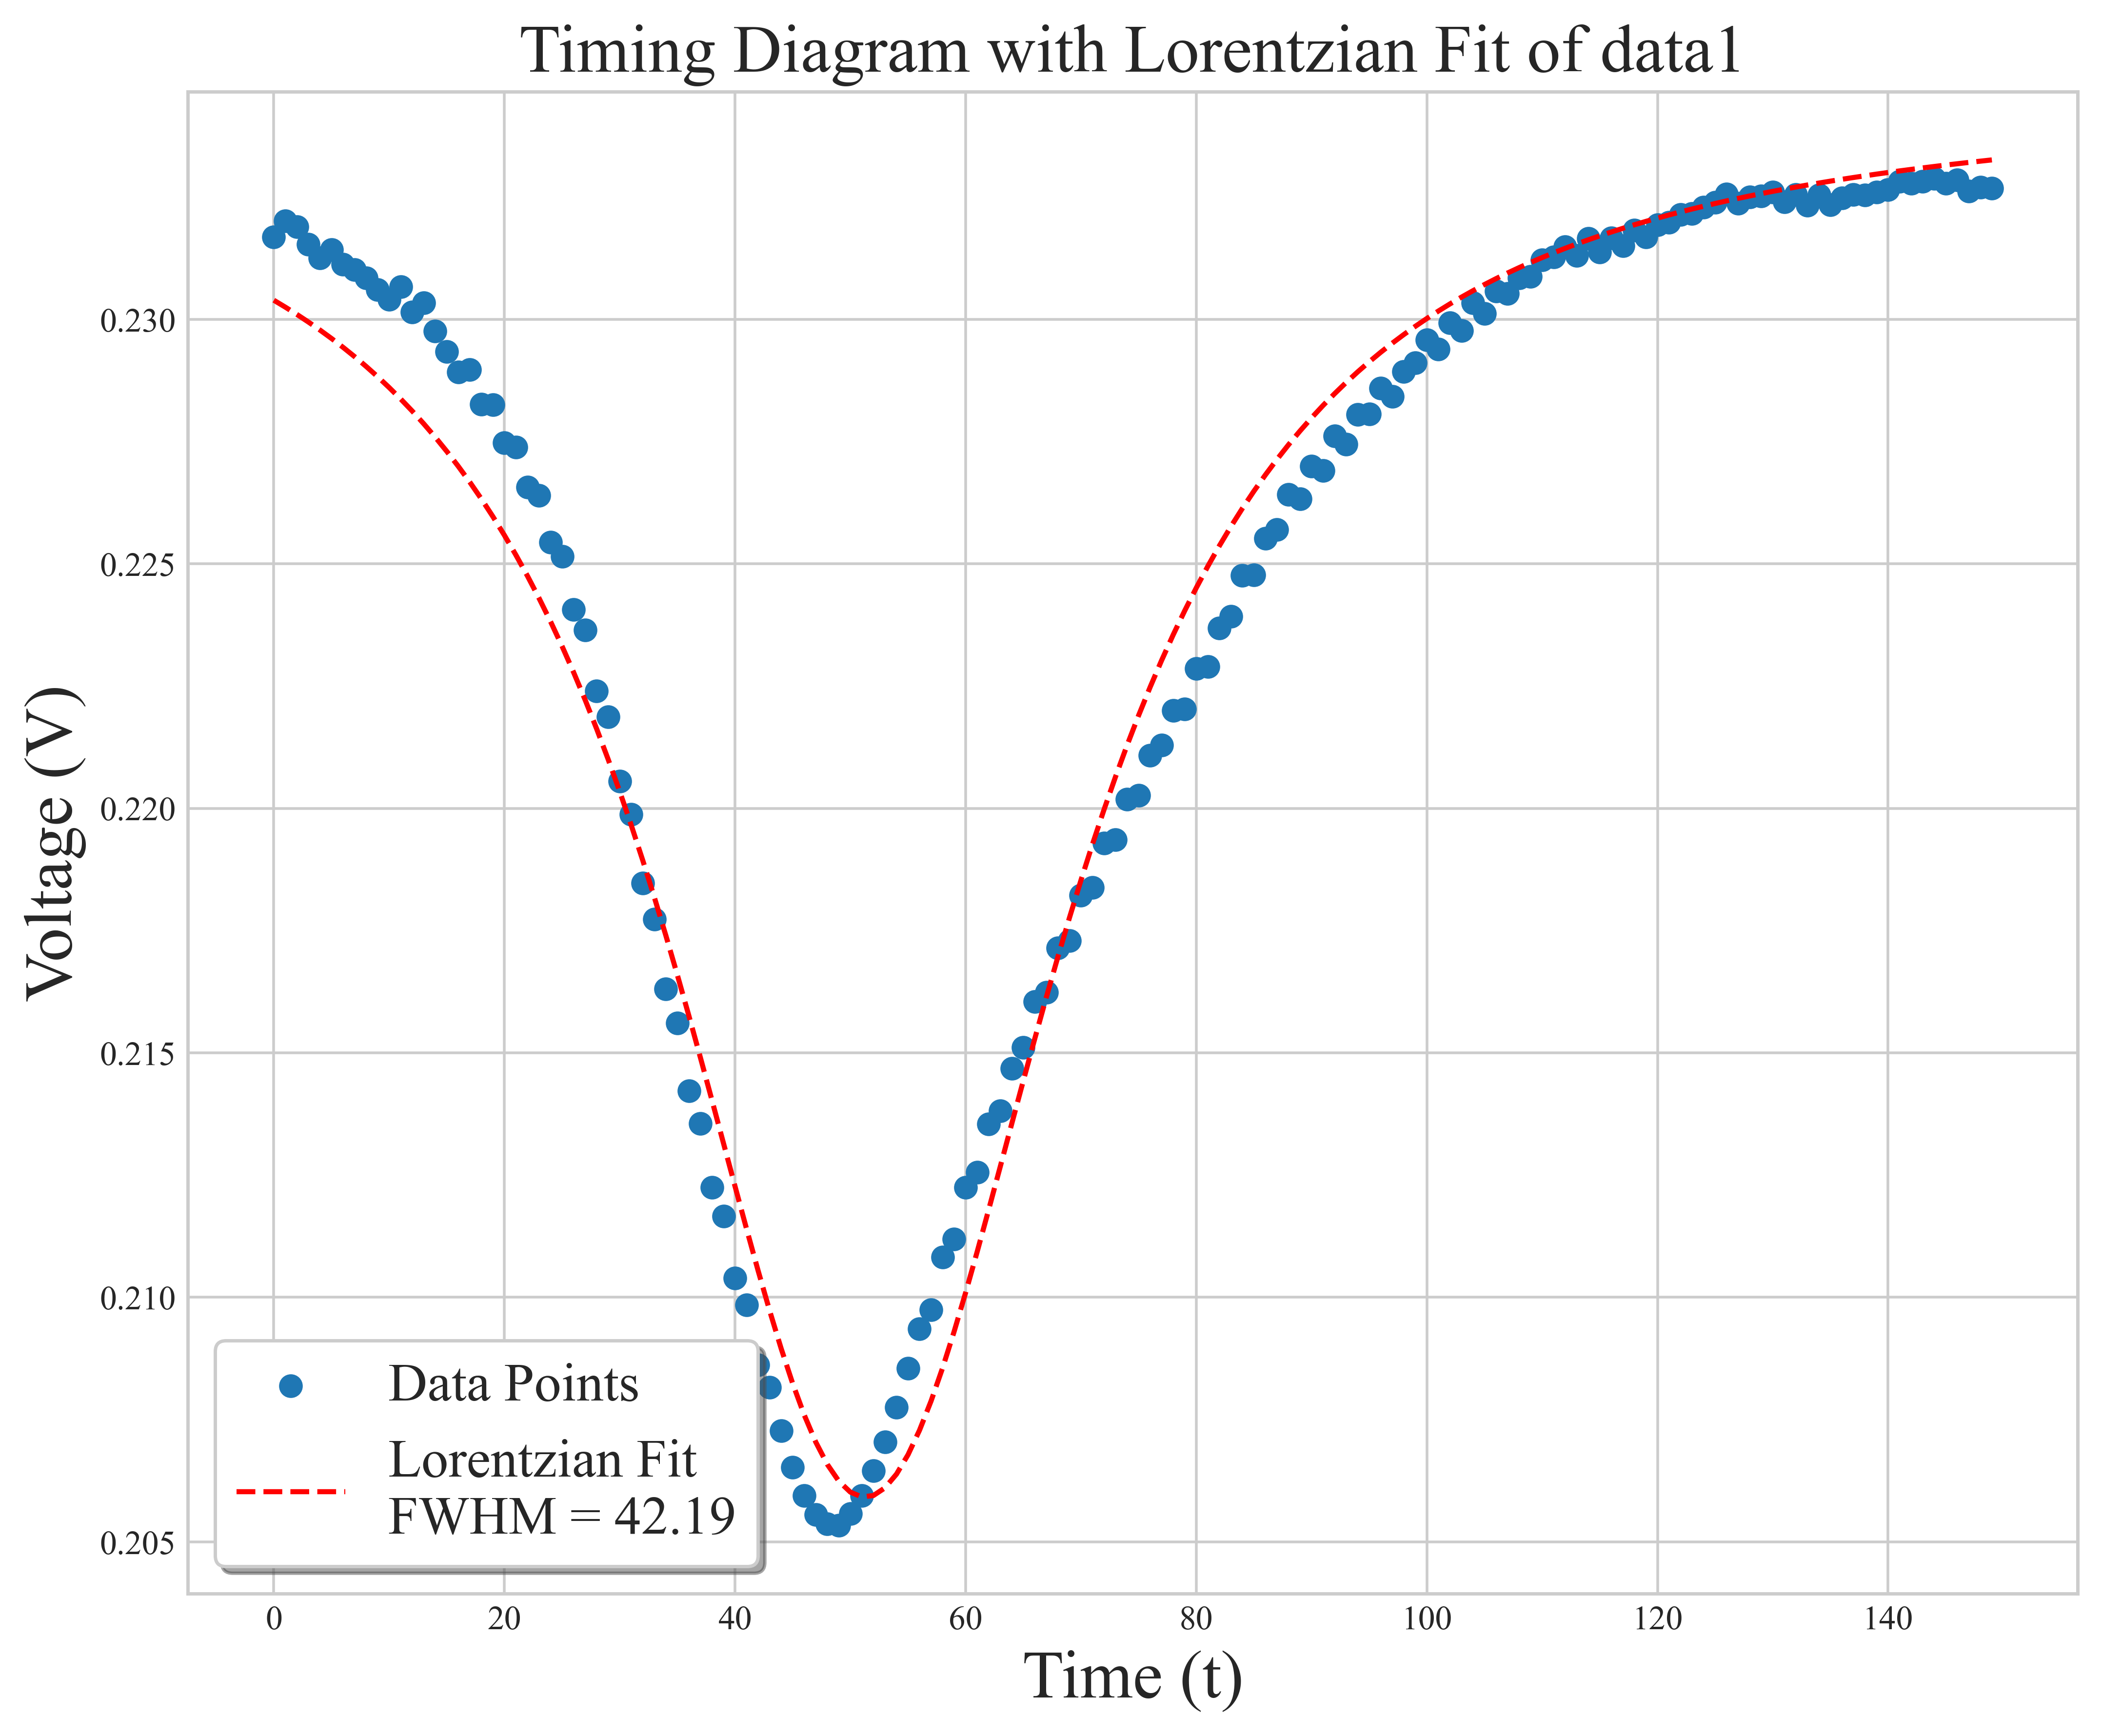

In [62]:
# 拟合时序图（2）

initial_guess = [selected_t1[np.argmin(selected_y1)], 1, max(selected_y1) - min(selected_y1), min(selected_y1)]
params, covariance = curve_fit(lorentzian, selected_t1, selected_y1, p0=initial_guess)
t0, fwhm, A, y0 = params
fitted_y = lorentzian(selected_t1, *params)

plt.figure()
plt.scatter(selected_t1, selected_y1, label='Data Points')
plt.plot(selected_t1, fitted_y, 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('Time (t)')
plt.ylabel('Voltage (V)')
plt.title('Timing Diagram with Lorentzian Fit of data1', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

In [63]:
# 后续计算

fwhm2_1 = 53.62
Delta_t = fwhm2_1 * 10e-3 /200
Delta_B2 = 2 * B_prime * np.sin(np.pi * 50 * Delta_t) * 1e-4
t2 = 2 / (gamma * Delta_B2)
print(f'利用平均时序图拟合得到弛豫时间 T2 = {1e9 * t2:.4f} (ns)')

fwhm2_2 = 42.19
Delta_t = fwhm2_2 * 10e-3 /200
Delta_B2 = 2 * B_prime * np.sin(np.pi * 50 * Delta_t) * 1e-4
t2 = 2 / (gamma * Delta_B2)
print(f'利用时序图拟合得到弛豫时间 T2 = {1e9 * t2:.4f} (ns)')

利用平均时序图拟合得到弛豫时间 T2 = 5.4265 (ns)
利用时序图拟合得到弛豫时间 T2 = 6.8187 (ns)


In [64]:
# 其它数据的处理

# 加载数据
data2 = pd.read_csv('data/data2.csv', skiprows=1)
t2 = data2.iloc[:, 0] # 时间单位为“1个单位时间”
x2 = data2.iloc[:, 1]
y2 = data2.iloc[:, 2]
# x数据
T_x2 = 1000
average_xt2 = average_periodization(x2, t2, T_x2)
# 滤波
smoothed_x2 = savgol_filter(average_xt2['X'].values, window_length, polyorder)
# 截取
selected_x2 = smoothed_x2[150:600]
# y数据
T_y2 = 1000
average_yt2 = average_periodization(y2, t2, T_y2)
# 滤波
smoothed_y2 = savgol_filter(average_yt2['X'].values, window_length, polyorder)
selected_y2 = smoothed_y2[150:600]
# 时间序列
#selected_t2 = average_yt2['time']
selected_t2 = np.arange(450)

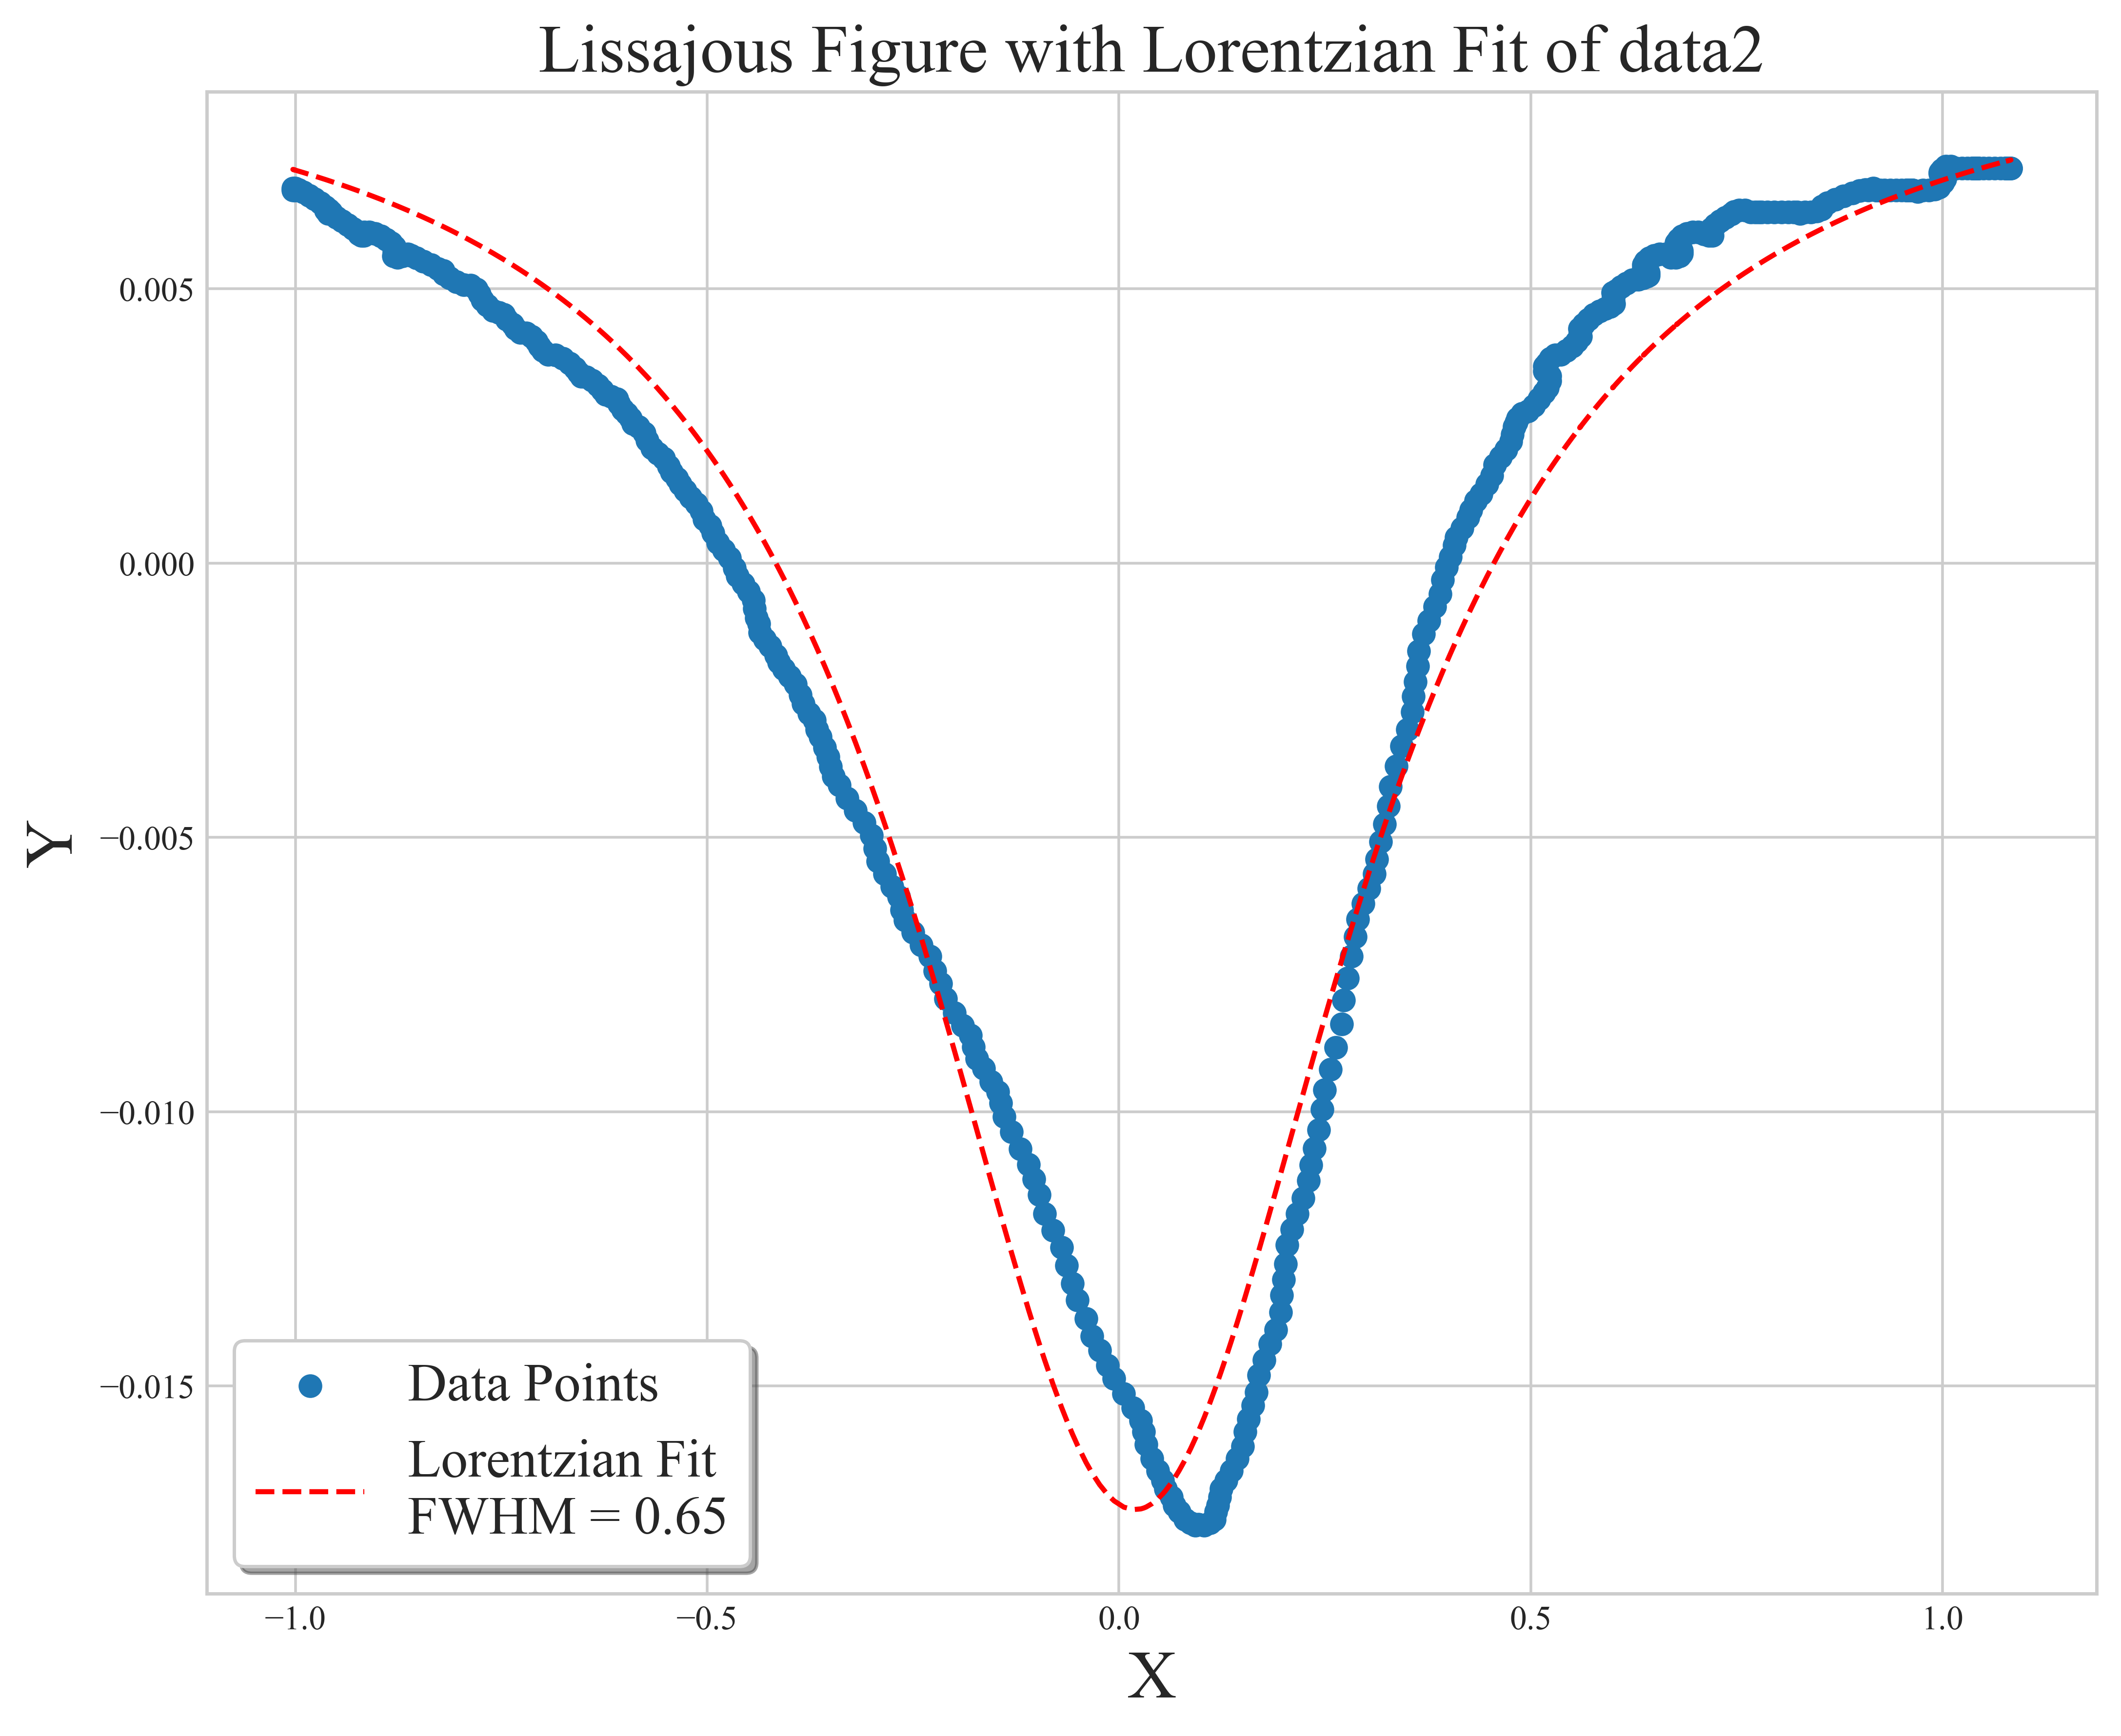

In [65]:
# 绘制李萨如图
params, covariance = curve_fit(lorentzian, selected_x2, selected_y2, p0=[selected_x2.mean(), 1, max(selected_y2) - min(selected_y2), min(selected_y2)])
x0, fwhm, A, y0 = params
plt.figure()
plt.scatter(selected_x2, selected_y2, label='Data Points')
plt.plot(selected_x2, lorentzian(selected_x2, *params), 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lissajous Figure with Lorentzian Fit of data2', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

# 可以发现这个的FWHM还是0.65，虽然感觉有点不准

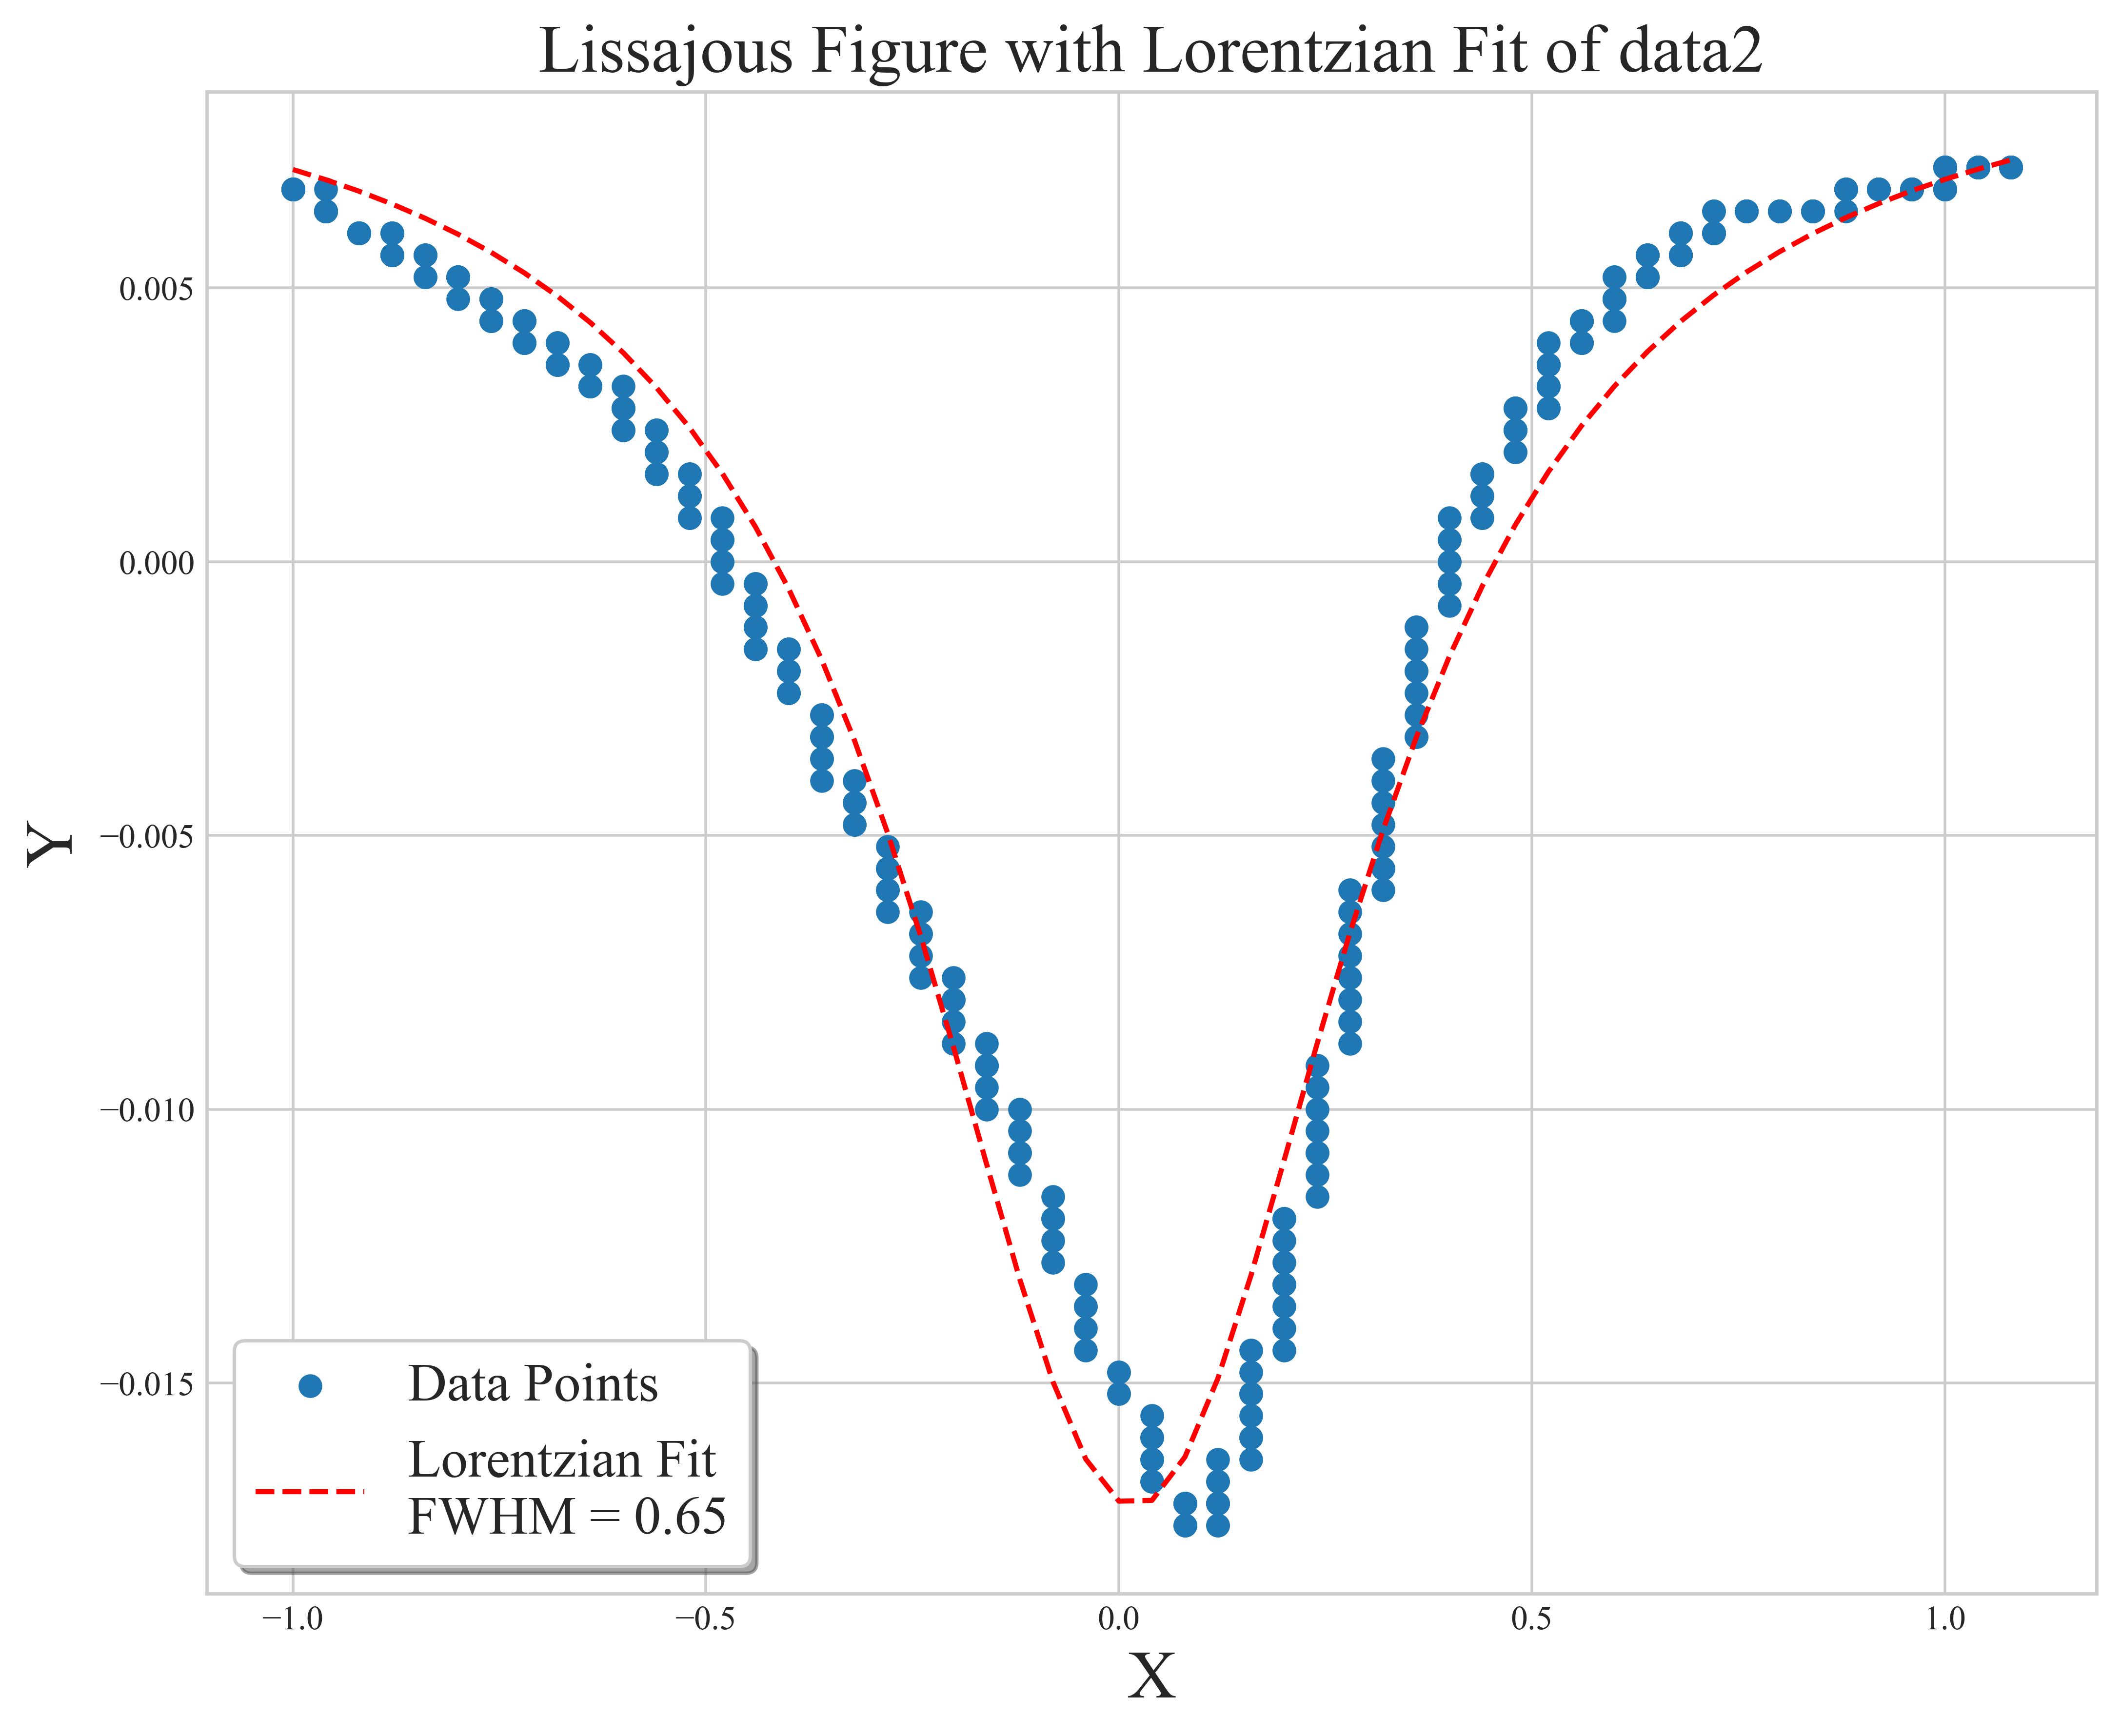

In [66]:
# 考虑另一个思路

another_x2 = x2[150:600]
another_y2 = y2[150:600]
smoothed_another_x2 = savgol_filter(another_x2, window_length, polyorder)
smoothed_another_y2 = savgol_filter(another_y2, window_length, polyorder)
# 绘制李萨如图
params, covariance = curve_fit(lorentzian, selected_x2, selected_y2, p0=[selected_x2.mean(), 1, max(selected_y2) - min(selected_y2), min(selected_y2)])
x0, fwhm, A, y0 = params
plt.figure()
plt.scatter(another_x2, another_y2, label='Data Points')
plt.plot(another_x2, lorentzian(another_x2, *params), 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lissajous Figure with Lorentzian Fit of data2', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

# 可以发现FWHM也是0.65

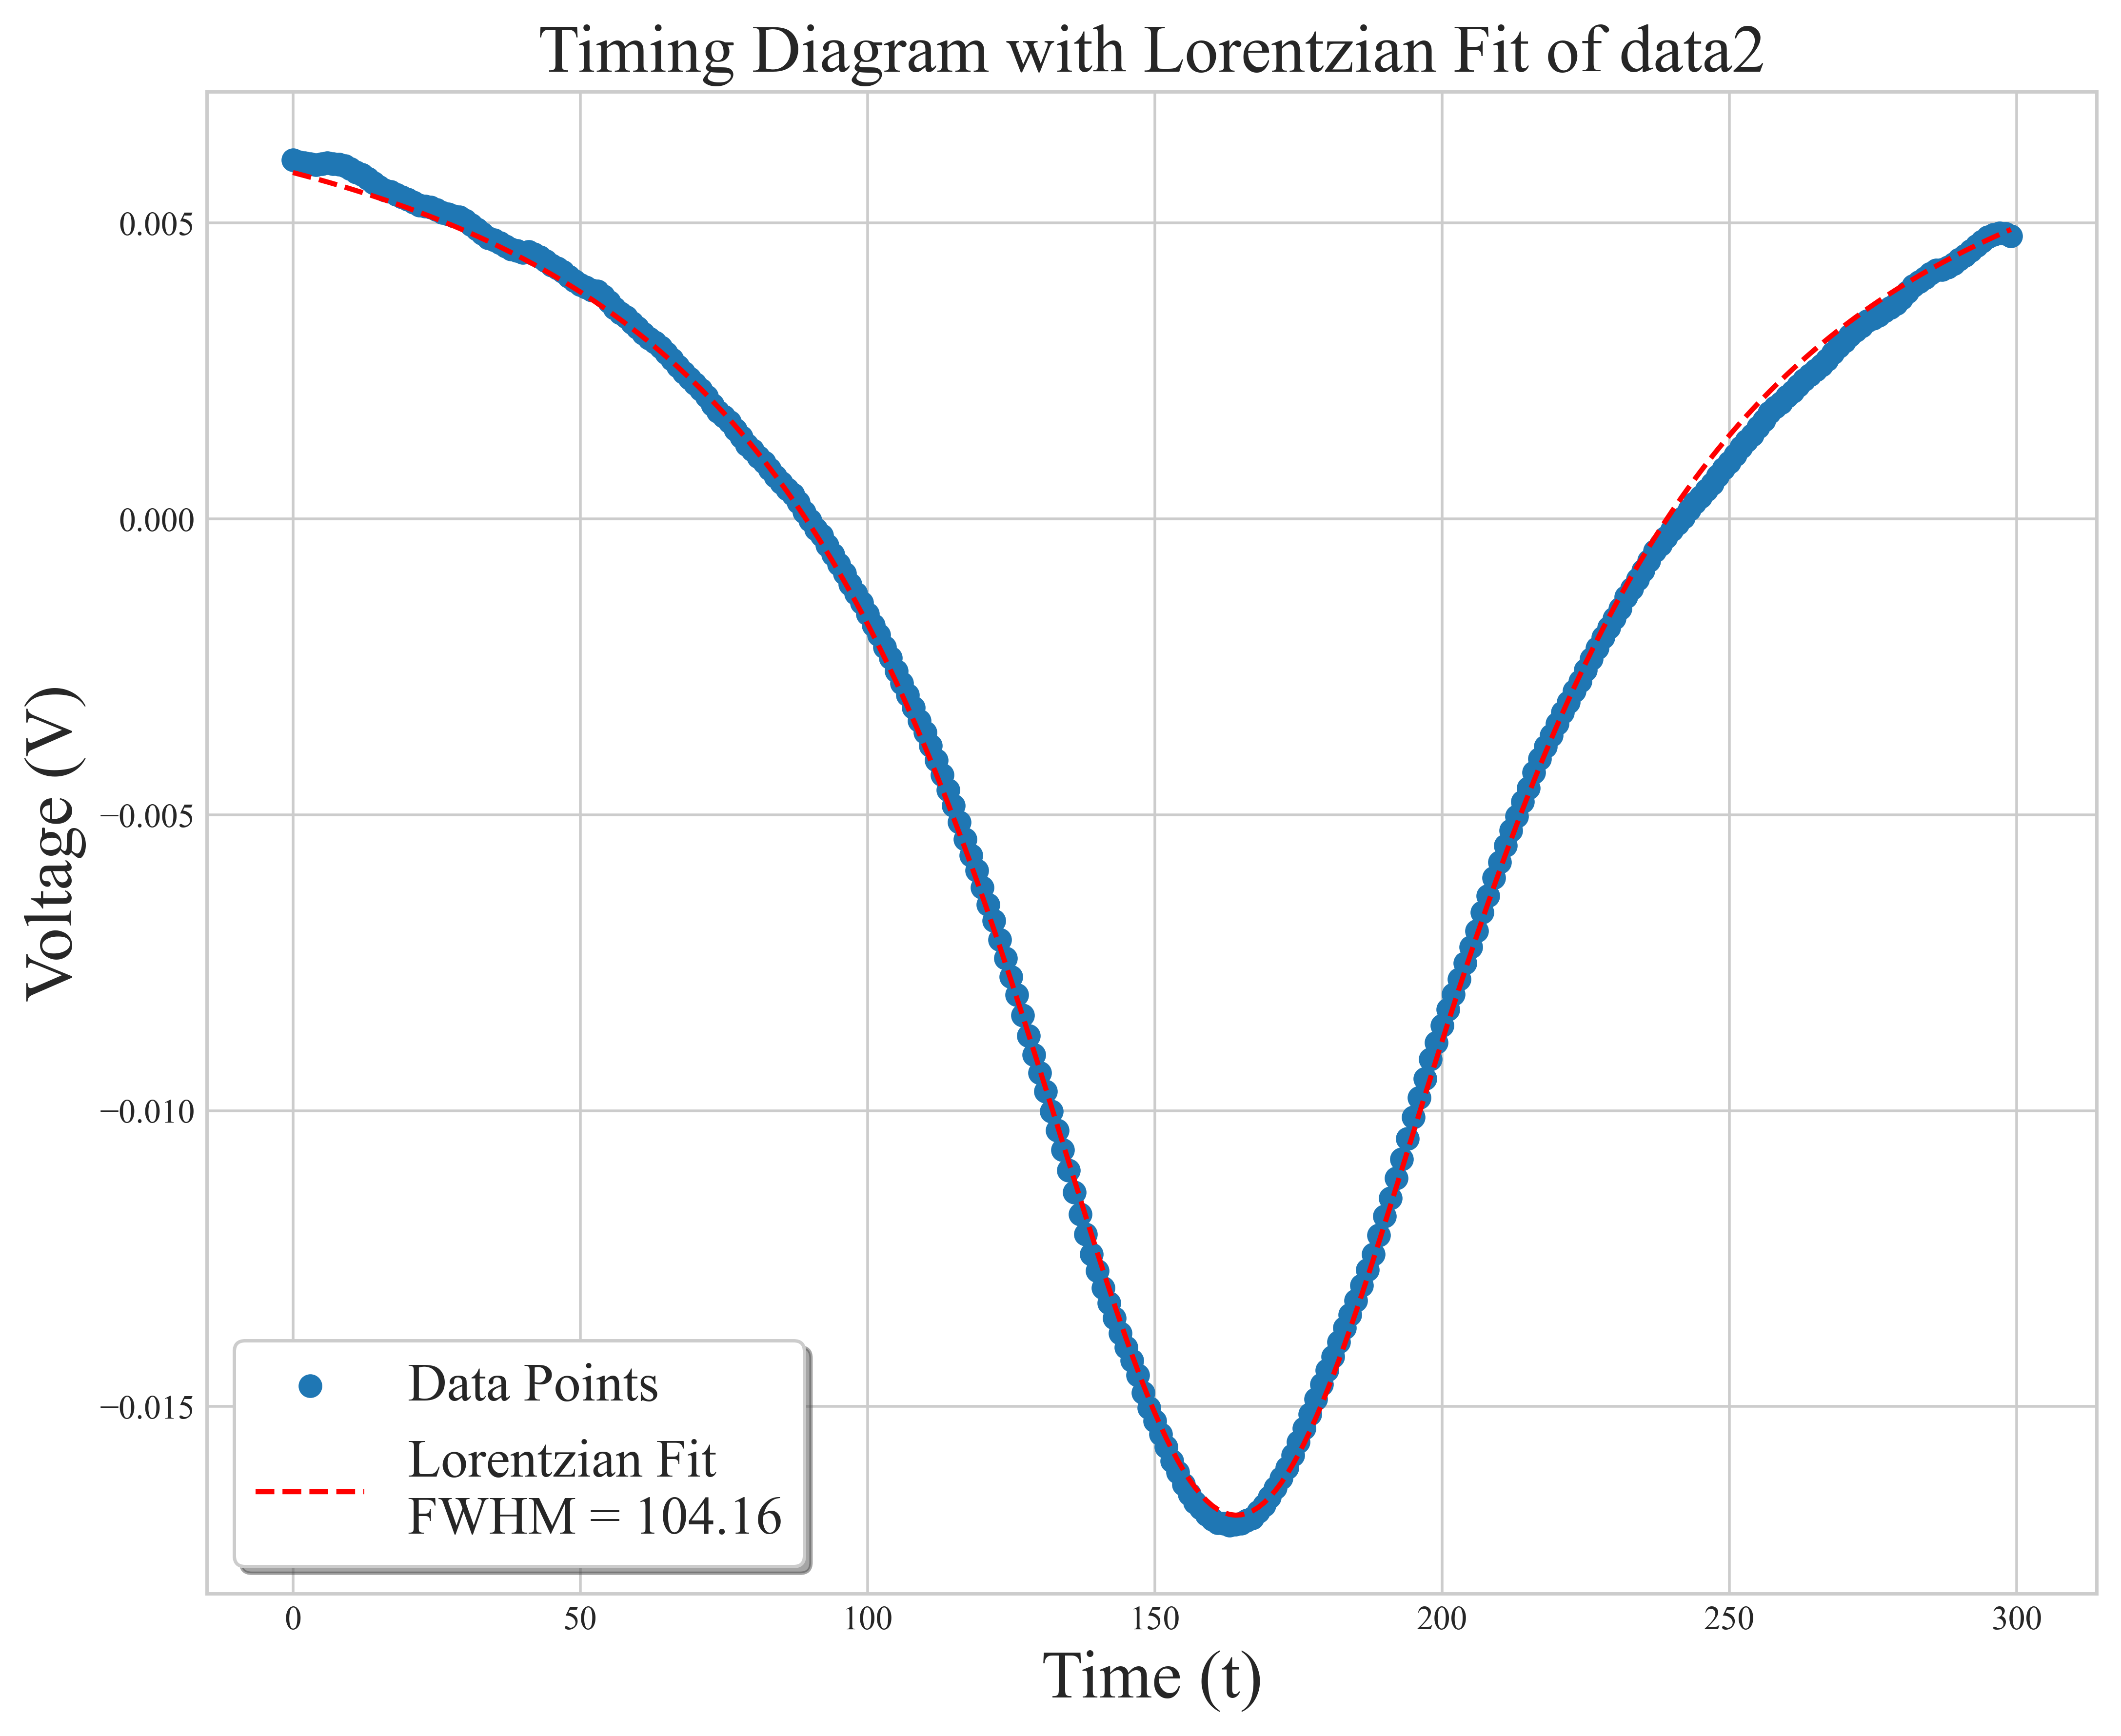

利用平均时序图拟合得到弛豫时间 T2 = 6.9015 (ns)


In [67]:
# 时序图处理

average_yt2 = average_periodization(y2, t2, 500)
# 滤波
smoothed_average_y2 = savgol_filter(average_yt2['X'].values, window_length, polyorder)[200:500]
# 时间序列
smoothed_average_t2 = np.arange(300)
# 拟合与绘制
initial_guess = [smoothed_average_t2[np.argmin(smoothed_average_y2)], 1, max(smoothed_average_y2) - min(smoothed_average_y2), min(smoothed_average_y2)]
params, covariance = curve_fit(lorentzian, smoothed_average_t2, smoothed_average_y2, p0=initial_guess)
t0, fwhm, A, y0 = params
fitted_y = lorentzian(smoothed_average_t2, *params)
plt.figure()
plt.scatter(smoothed_average_t2, smoothed_average_y2, label='Data Points')
plt.plot(smoothed_average_t2, fitted_y, 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('Time (t)')
plt.ylabel('Voltage (V)')
plt.title('Timing Diagram with Lorentzian Fit of data2', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

Delta_t = fwhm * 10e-3 /500
Delta_B2 = 2 * B_prime * np.sin(np.pi * 50 * Delta_t) * 1e-4
t2 = 2 / (gamma * Delta_B2)
print(f'利用平均时序图拟合得到弛豫时间 T2 = {1e9 * t2:.4f} (ns)')

# 可以发现已经有多个结果处理出来在 7 (ns) 附近

In [68]:
# 加载数据
data3 = pd.read_csv('data/data3.csv', skiprows=1)
t3 = data3.iloc[:, 0] # 时间单位为“1个单位时间”
x3 = data3.iloc[:, 1]
y3 = data3.iloc[:, 2]
# x数据
T_x3 = 1000
average_xt3 = average_periodization(x3, t3, T_x3)
# 滤波
smoothed_x3 = savgol_filter(average_xt3['X'].values, window_length, polyorder)
# 截取
selected_x3 = smoothed_x3[200:700]
# y数据
T_y3 = 1000
average_yt3 = average_periodization(y3, t3, T_y3)
# 滤波
smoothed_y3 = savgol_filter(average_yt3['X'].values, window_length, polyorder)
selected_y3 = smoothed_y3[200:700]
# 时间序列
#selected_t3 = average_yt3['time']
selected_t3 = np.arange(500)

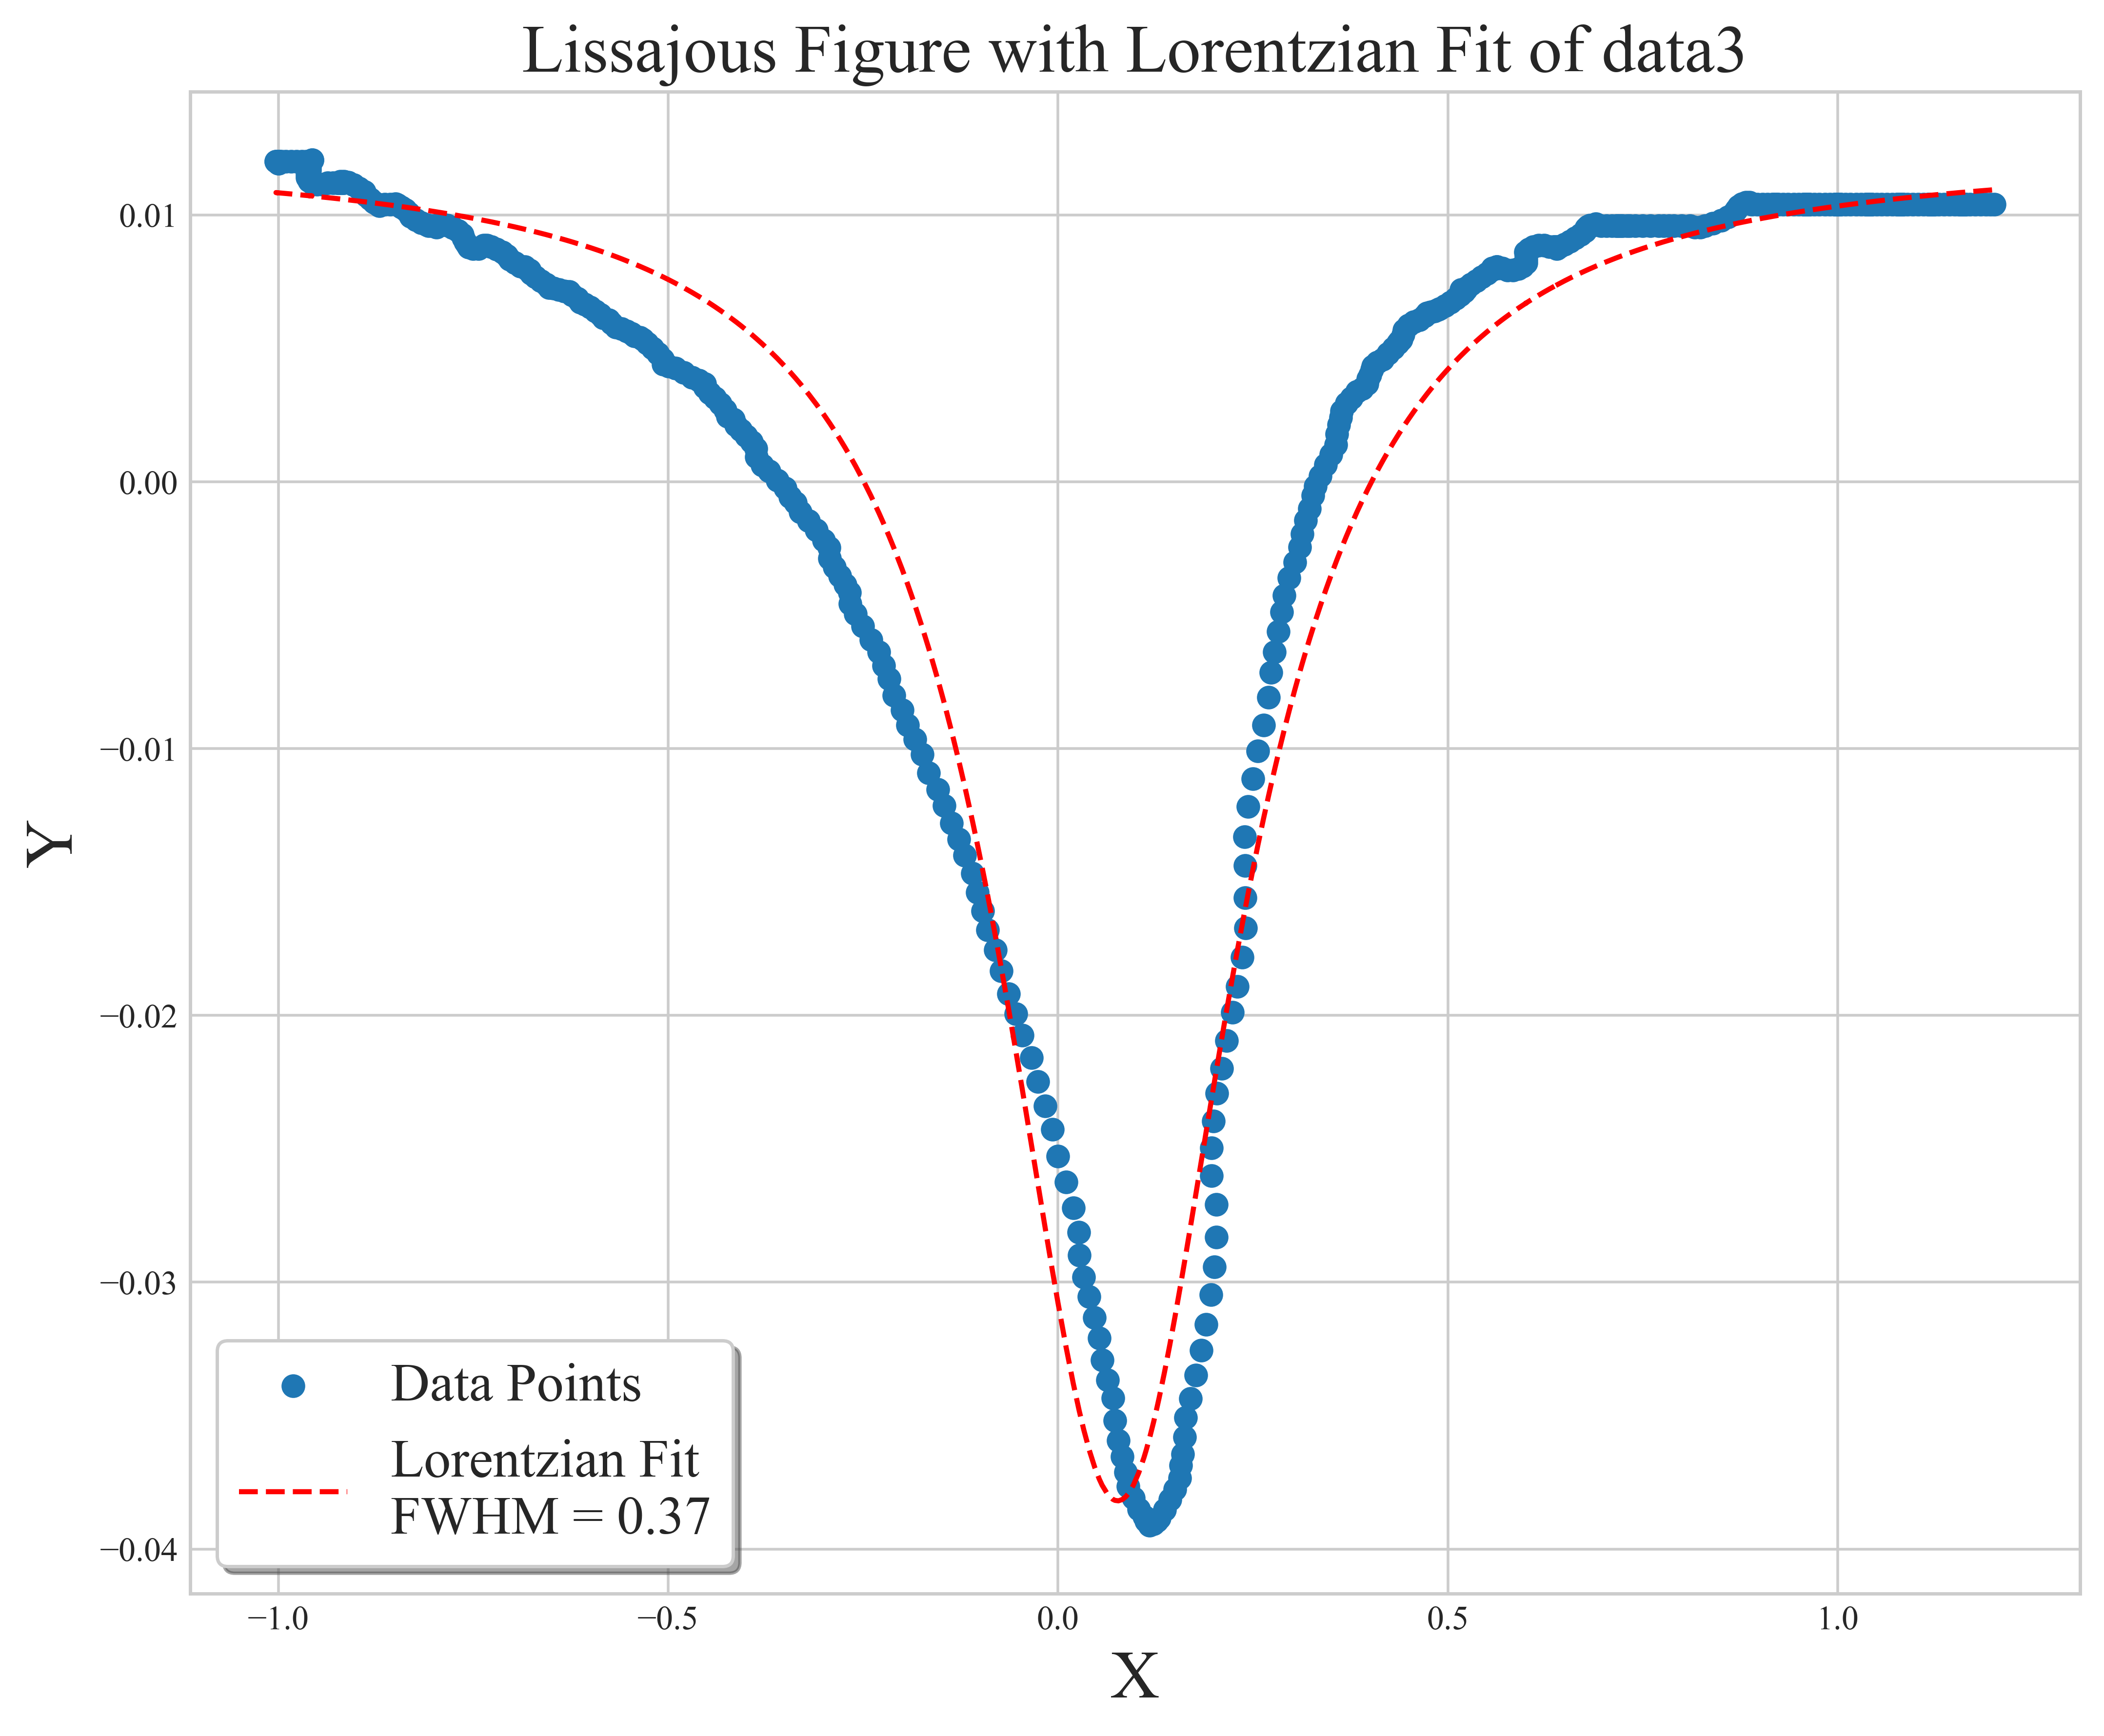

In [69]:
# 绘制李萨如图
params, covariance = curve_fit(lorentzian, selected_x3, selected_y3, p0=[selected_x3.mean(), 1, max(selected_y3) - min(selected_y3), min(selected_y3)])
x0, fwhm, A, y0 = params
plt.figure()
plt.scatter(selected_x3, selected_y3, label='Data Points')
plt.plot(selected_x3, lorentzian(selected_x3, *params), 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lissajous Figure with Lorentzian Fit of data3', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

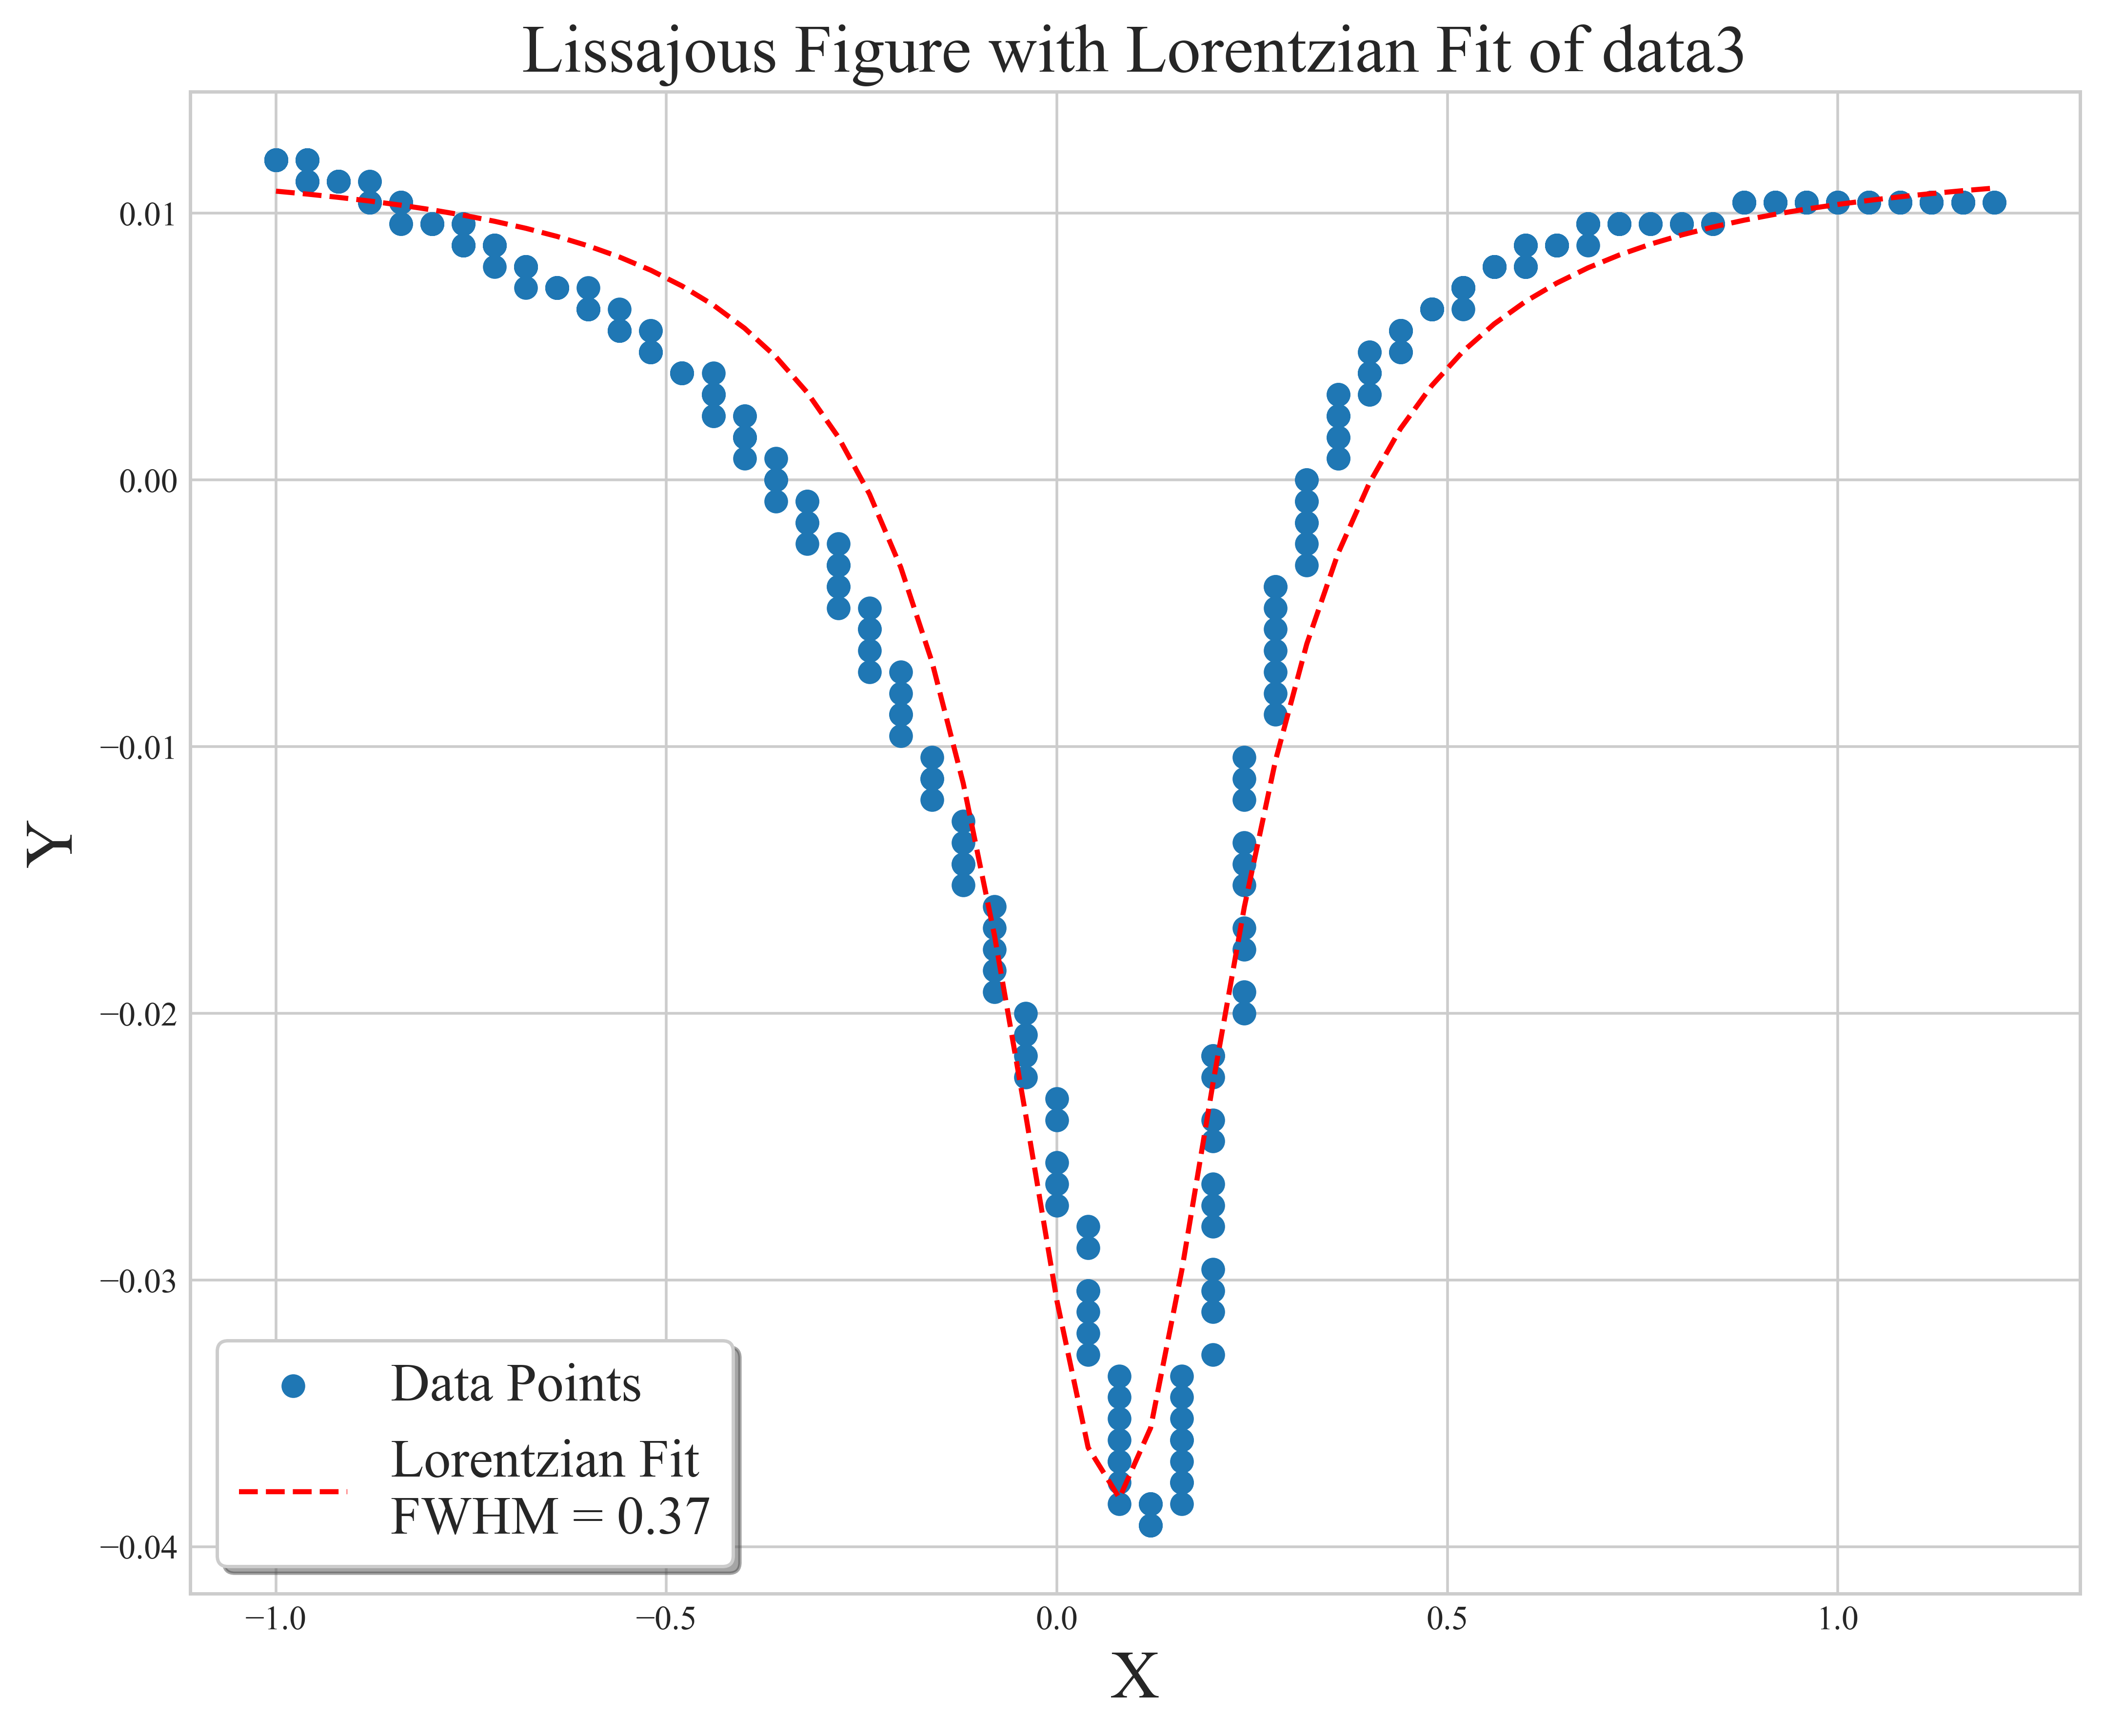

In [70]:
# 考虑另一个思路

another_x3 = x3[200:700]
another_y3 = y3[200:700]
smoothed_another_x3 = savgol_filter(another_x3, window_length, polyorder)
smoothed_another_y3 = savgol_filter(another_y3, window_length, polyorder)
# 绘制李萨如图
params, covariance = curve_fit(lorentzian, selected_x3, selected_y3, p0=[selected_x3.mean(), 1, max(selected_y3) - min(selected_y3), min(selected_y3)])
x0, fwhm, A, y0 = params
plt.figure()
plt.scatter(another_x3, another_y3, label='Data Points')
plt.plot(another_x3, lorentzian(another_x3, *params), 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lissajous Figure with Lorentzian Fit of data3', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

# 可以发现FWHM也是0.37

In [71]:
# 后续计算

xpp = np.max(smoothed_x3) - np.min(smoothed_x3)
B_prime = (6.85 - 5.80) * slope
x2B = 2 * B_prime / xpp
Delta_B = fwhm * x2B * 1e-4
gamma = 2 * np.pi * 2.0036 * 5.79e-11 / (4.14e-21)
t2 = 2 / (gamma * Delta_B)
print(f'利用李萨如图拟合得到弛豫时间 T2 = {1e9 * t2:.4f} (ns)')

# 可以看出这显然不对，所以这个数据大概废掉了

利用李萨如图拟合得到弛豫时间 T2 = 13.2612 (ns)


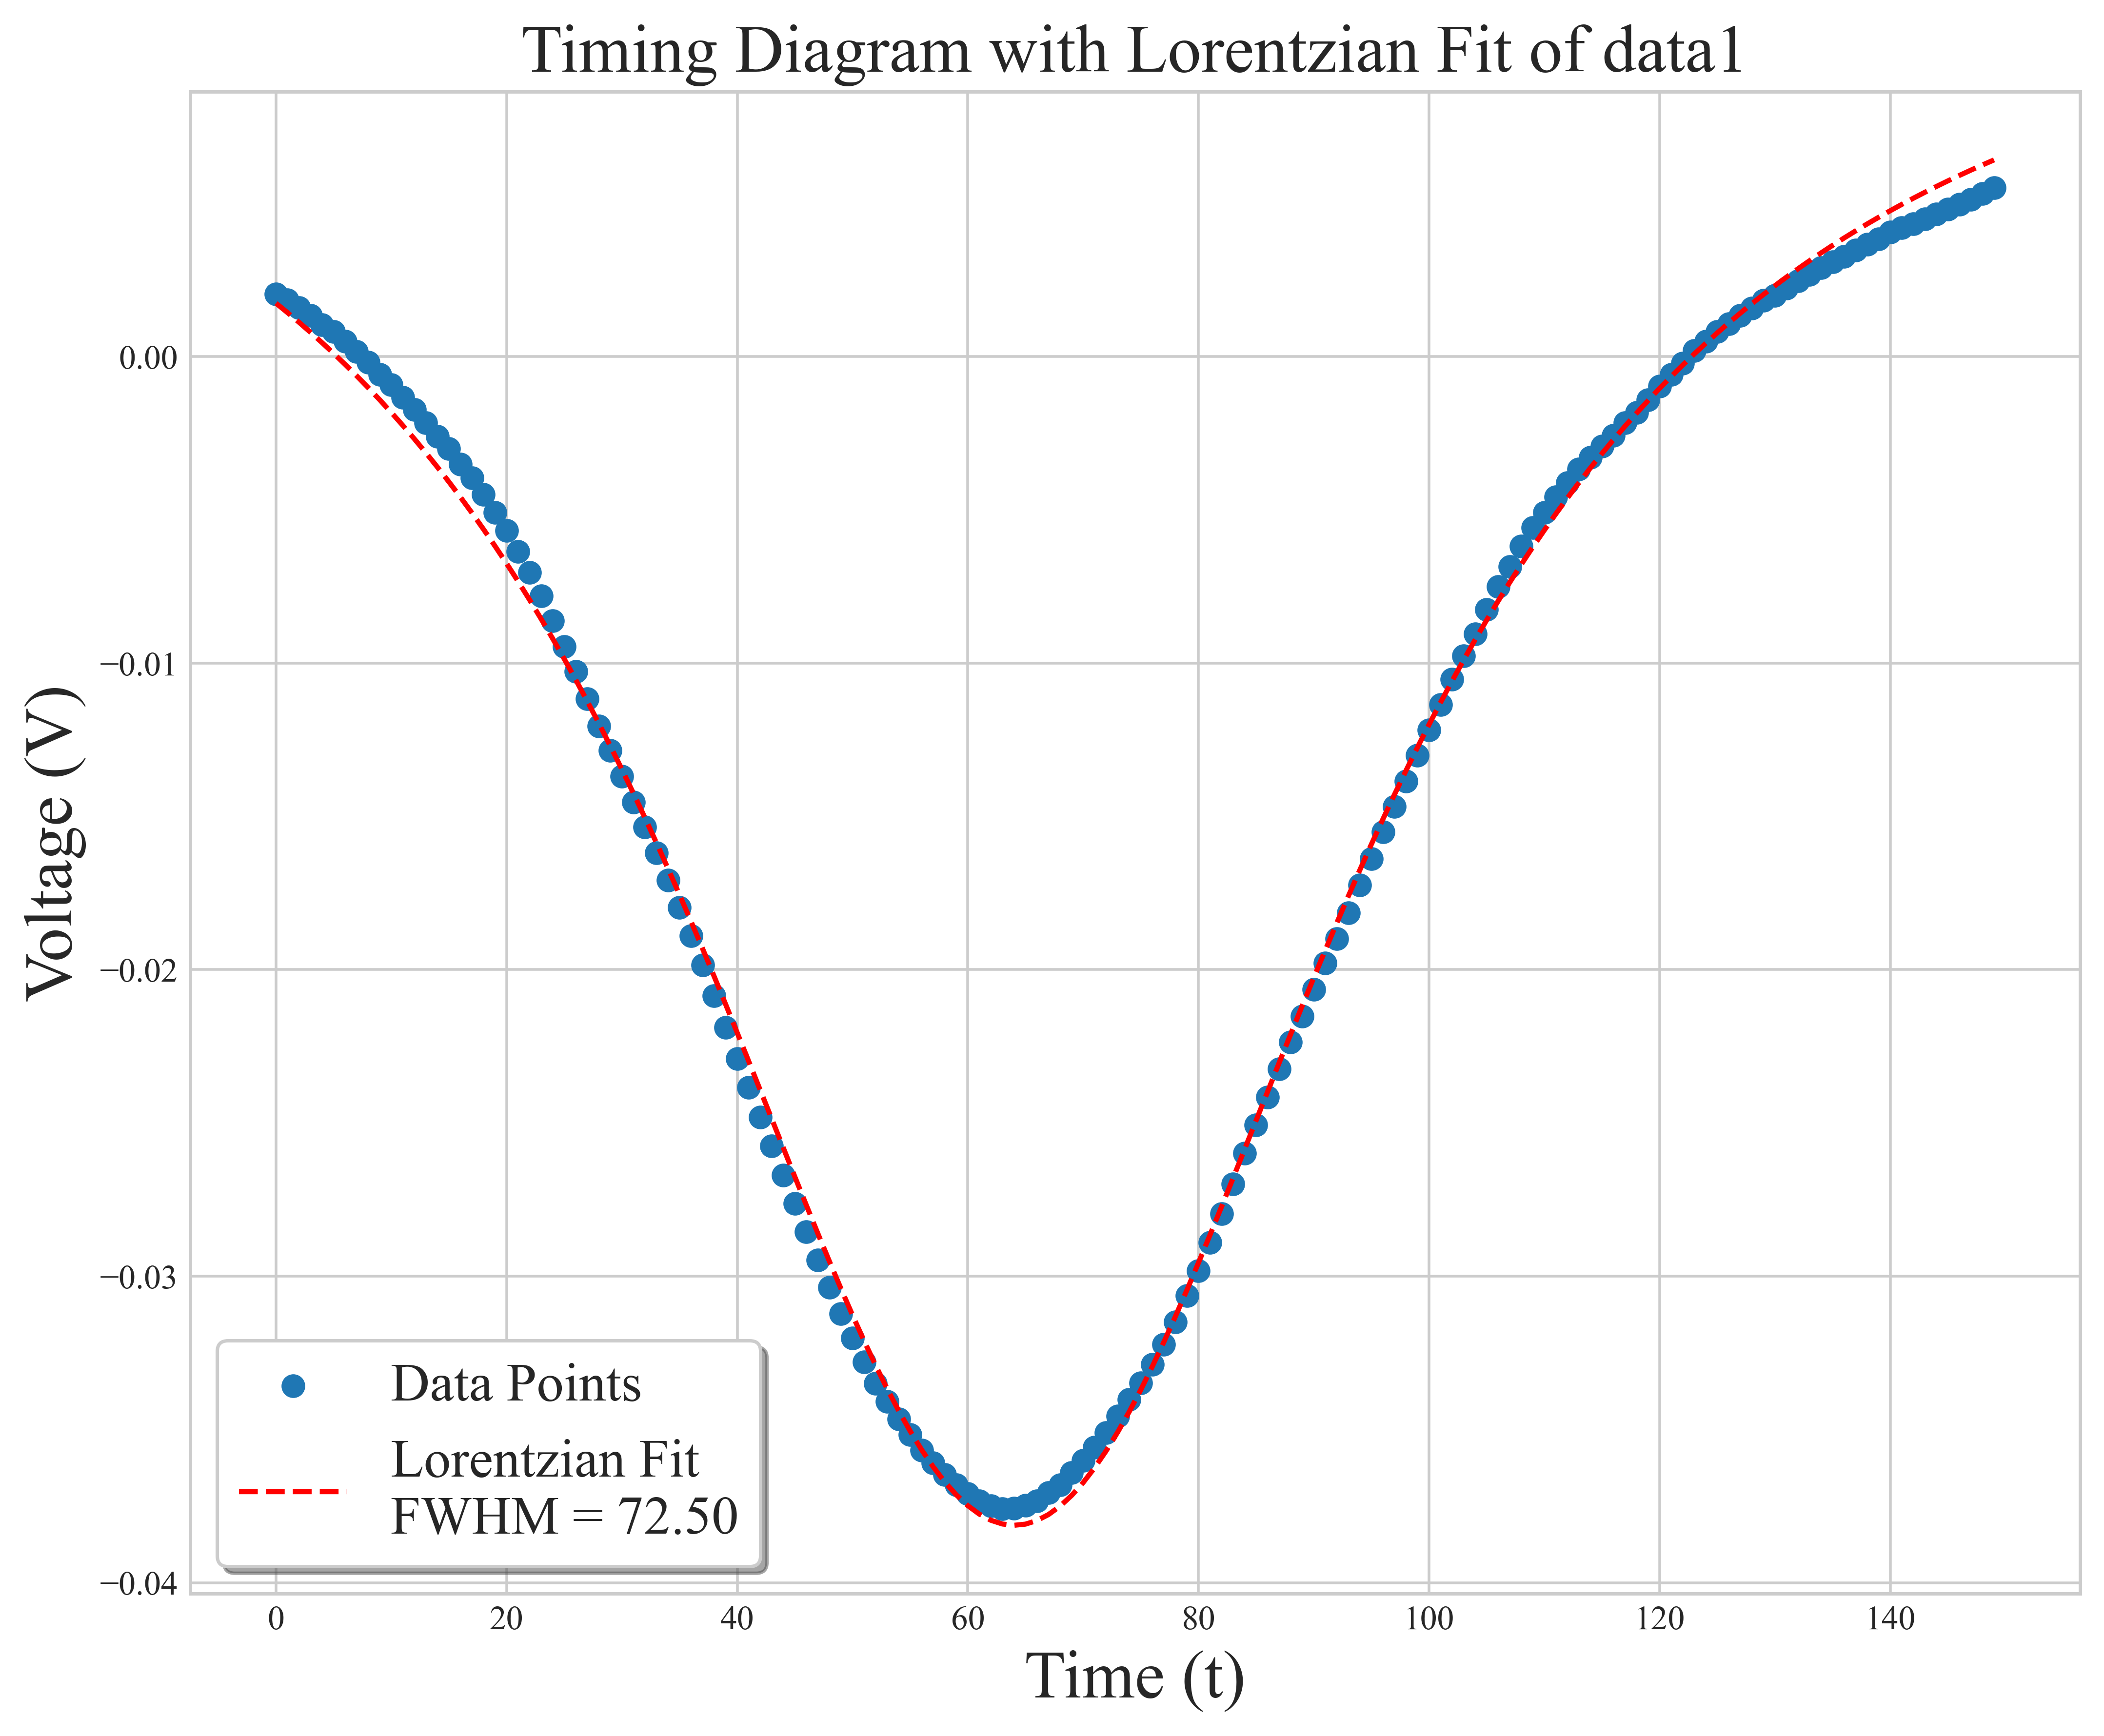

利用平均时序图拟合得到弛豫时间 T2 = 9.8241 (ns)


In [72]:
# 时序图处理

average_yt3 = average_periodization(y3, t3, 500)
# 滤波
smoothed_average_y3 = savgol_filter(average_yt3['X'].values, window_length, polyorder)[350:500]
# 时间序列
smoothed_average_t3 = np.arange(150)
# 拟合与绘制
initial_guess = [smoothed_average_t3[np.argmin(smoothed_average_y3)], 1, max(smoothed_average_y3) - min(smoothed_average_y3), min(smoothed_average_y3)]
params, covariance = curve_fit(lorentzian, smoothed_average_t3, smoothed_average_y3, p0=initial_guess)
t0, fwhm, A, y0 = params
fitted_y = lorentzian(smoothed_average_t3, *params)
plt.figure()
plt.scatter(smoothed_average_t3, smoothed_average_y3, label='Data Points')
plt.plot(smoothed_average_t3, fitted_y, 'r--', label=f'Lorentzian Fit\nFWHM = {fwhm:.2f}')
plt.xlabel('Time (t)')
plt.ylabel('Voltage (V)')
plt.title('Timing Diagram with Lorentzian Fit of data1', fontsize=20)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.show()

Delta_t = fwhm * 10e-3 /500
Delta_B2 = 2 * B_prime * np.sin(np.pi * 50 * Delta_t) * 1e-4
t2 = 2 / (gamma * Delta_B2)
print(f'利用平均时序图拟合得到弛豫时间 T2 = {1e9 * t2:.4f} (ns)')

# 这个倒是还好……

In [73]:
# 关于实验二
u_col = np.array([6.6, 6.56, 6.61, 6.85, 6.93]) # GHz   
f_col = np.array([9.38, 9.37, 9.3725, 9.376, 9.375]) # Gs
B_col = vmc(u_col)

B_mean = B_col.mean()
f_mean = f_col.mean()
g = f_mean * 1e9 * 4.14e-21 / (B_mean * 1e-4 * 5.78838263e-11)
print(f'测量得到郎德g因子为：{g:.4f}（参考值：2.0036）')

# 误差
sigma_B2 = np.var(B_col, ddof=1)
sigma_f2 = np.var(f_col, ddof=1)
r_error = np.sqrt(sigma_B2/(B_mean**2) + sigma_f2/(f_mean**2))
print(f'一个标准差的置信区间下的相对误差为：{100 * r_error:.4f}%')

测量得到郎德g因子为：1.9906（参考值：2.0036）
一个标准差的置信区间下的相对误差为：0.1279%


In [74]:
100 * (g - 2.003) / 2.003

-0.6215518509144359